In [193]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/DS_DA_Projects/Marketing_Prediction")

data = pd.read_csv("data.csv", na_values=["", "NA"])

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [8, 6]  # Default figure size
plt.rcParams['figure.dpi'] = 100  # Controls display resolution

In [194]:
print(data.head())

   id  age      dist       income gender marital_status  target
0   1   73  4.371654    90-99,999      M              S       1
1   2   89  1.582733  100-149,999      M            NaN       1
2   3   85  1.223810    10-19,999      F              S       1
3   4   76  2.962427    90-99,999      M              M       1
4   5   76  2.594408    10-19,999      M              S       1


# prepare data

In [195]:
import pandas as pd
import numpy as np

# Replace missing or empty values in columns 4, 5, 6 with "unknown"
data.iloc[:, [3, 4, 5]] = data.iloc[:, [3, 4, 5]].applymap(lambda x: "unknown" if pd.isna(x) or x == "" else x)

# Replace income with appropriate midpoints or custom values
income_mapping = {
    "unknown": 6,              # replacing unknown with the median income level
    "Under $10k": 1,            # midpoint of "Under $10k"
    "10-19,999": 2,            # midpoint of "10-19,999"
    "20-29,999": 3,            # midpoint of "20-29,999"
    "30-39,999": 4,            # midpoint of "30-39,999"
    "40-49,999": 5,            # midpoint of "40-49,999"
    "50-59,999": 6,            # midpoint of "50-59,999"
    "60-69,999": 7,            # midpoint of "60-69,999"
    "70-79,999": 8,            # midpoint of "70-79,999"
    "80-89,999": 9,            # midpoint of "80-89,999"
    "90-99,999": 10,            # midpoint of "90-99,999"
    "100-149,999": 11,         # midpoint of "100-149,999"
    "150 - 174,999": 12,       # midpoint of "150 - 174,999"
    "175 - 199,999": 13,       # midpoint of "175 - 199,999"
    "200 - 249,999": 14,       # midpoint of "200 - 249,999"
    "250k+": 15               # custom value for "250k+"
}
data["income"] = data["income"].map(income_mapping).astype(int)

# Replace gender with 1 for male, 0 for female, and 0 for unknown
gender_mapping = {"M": 1, "F": 0, "unknown": 0}
data["gender"] = data["gender"].map(gender_mapping).astype(int)

# Replace marital_status with 1 for married, 0 for single, and 1 for unknown
marital_status_mapping = {"M": 1, "S": 0, "unknown": 1}
data["marital_status"] = data["marital_status"].map(marital_status_mapping).astype(int)

# Convert target to categorical values (0 or 1)
data["target"] = data["target"].astype(int)

# Convert distance (dist) column to integer
data["dist"] = data["dist"].astype(int)

Male is 1 and female is 0, married is 1 and single is 0, finally, response is 1 and no response is 0. 

In [196]:
print(data.head())

   id  age  dist  income  gender  marital_status  target
0   1   73     4      10       1               0       1
1   2   89     1      11       1               1       1
2   3   85     1       2       0               0       1
3   4   76     2      10       1               1       1
4   5   76     2       2       1               0       1


proportion of subset that corresponds to responses.

In [197]:
# Create contingency table for gender/marital status vs target
predictors = pd.DataFrame({
    'Single': [data[(data['gender'] == 0) & (data['marital_status'] == 0)]['target'].mean(),
               data[(data['gender'] == 1) & (data['marital_status'] == 0)]['target'].mean()],
    'Married': [data[(data['gender'] == 0) & (data['marital_status'] == 1)]['target'].mean(),
                data[(data['gender'] == 1) & (data['marital_status'] == 1)]['target'].mean()]
}, index=['Female', 'Male'])

print("Proportion of Group that Responded") 
print(predictors)

Proportion of Group that Responded
          Single   Married
Female  0.224093  0.219920
Male    0.214156  0.304501


# Evaluate Logistic Regression


Top 10 interaction combinations by lift at 40%:
     num_interactions                                       interactions  \
697                 6  ((age, dist), (age, income), (dist, income), (...   
887                 7  ((age, dist), (age, income), (age, marital_sta...   
747                 6  ((age, dist), (age, marital_status), (dist, in...   
480                 5  ((age, dist), (age, marital_status), (dist, in...   
728                 6  ((age, dist), (age, gender), (dist, income), (...   
49                  2         ((dist, gender), (gender, marital_status))   
904                 7  ((age, dist), (age, gender), (age, marital_sta...   
968                 8  ((age, dist), (age, income), (age, gender), (a...   
844                 6  ((age, marital_status), (dist, income), (dist,...   
936                 7  ((age, income), (age, gender), (age, marital_s...   

     lift_at_40  
697   60.829493  
887   60.829493  
747   60.829493  
480   60.829493  
728   60.368664  
49    

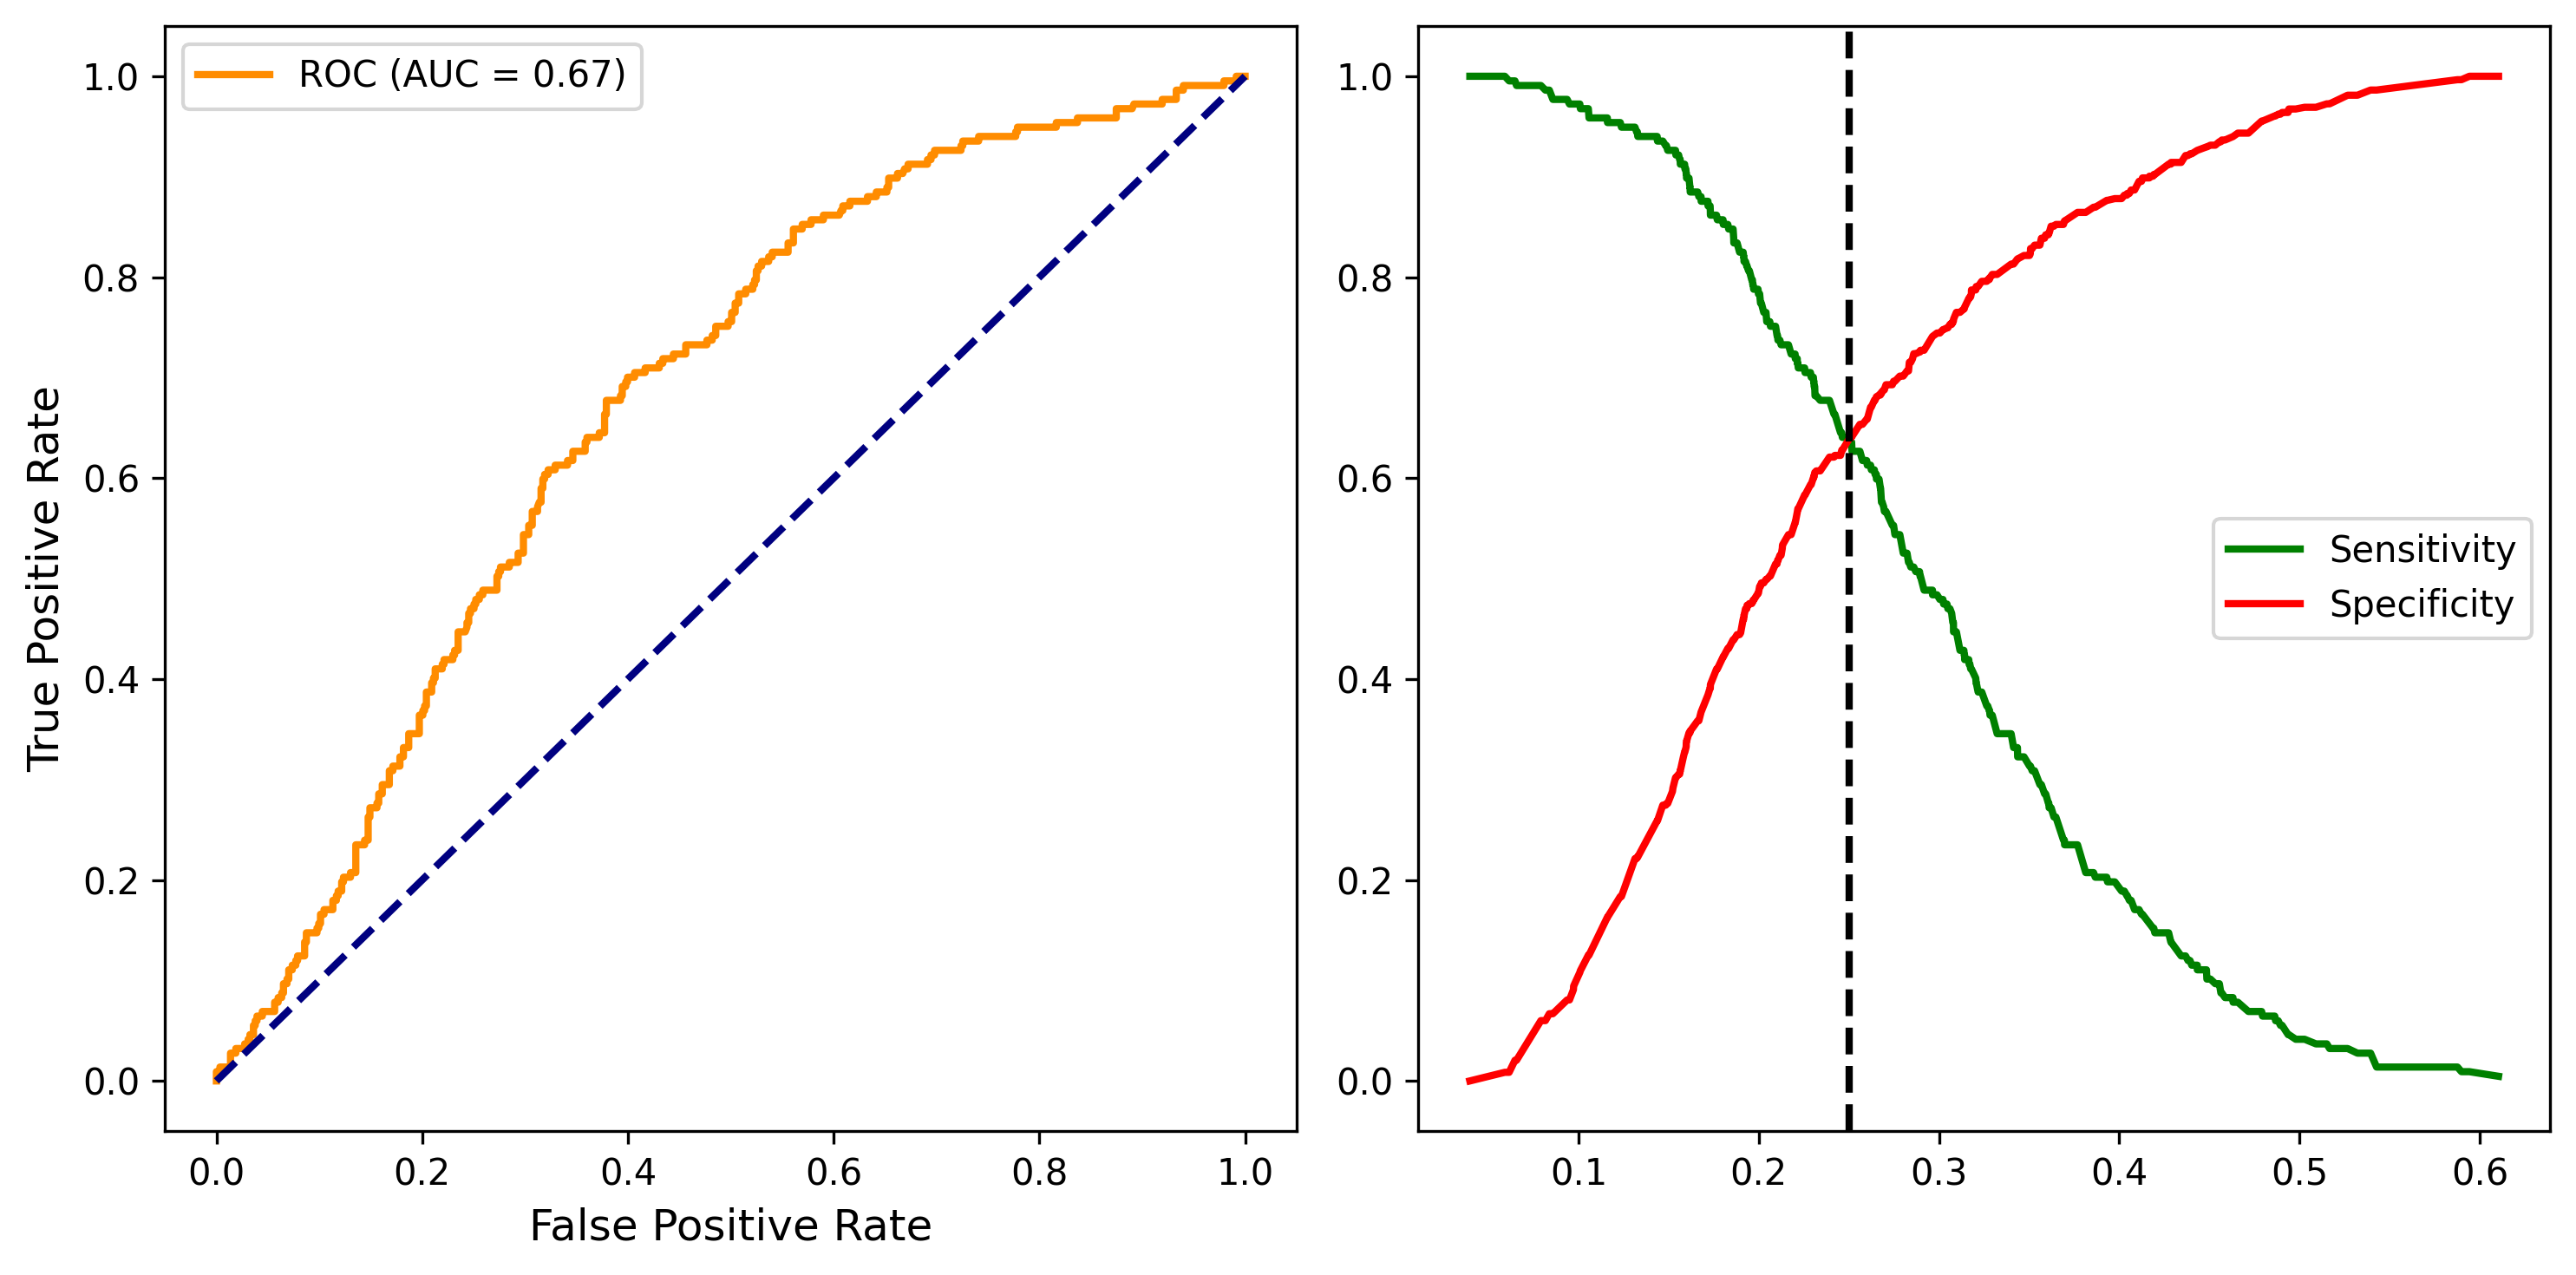

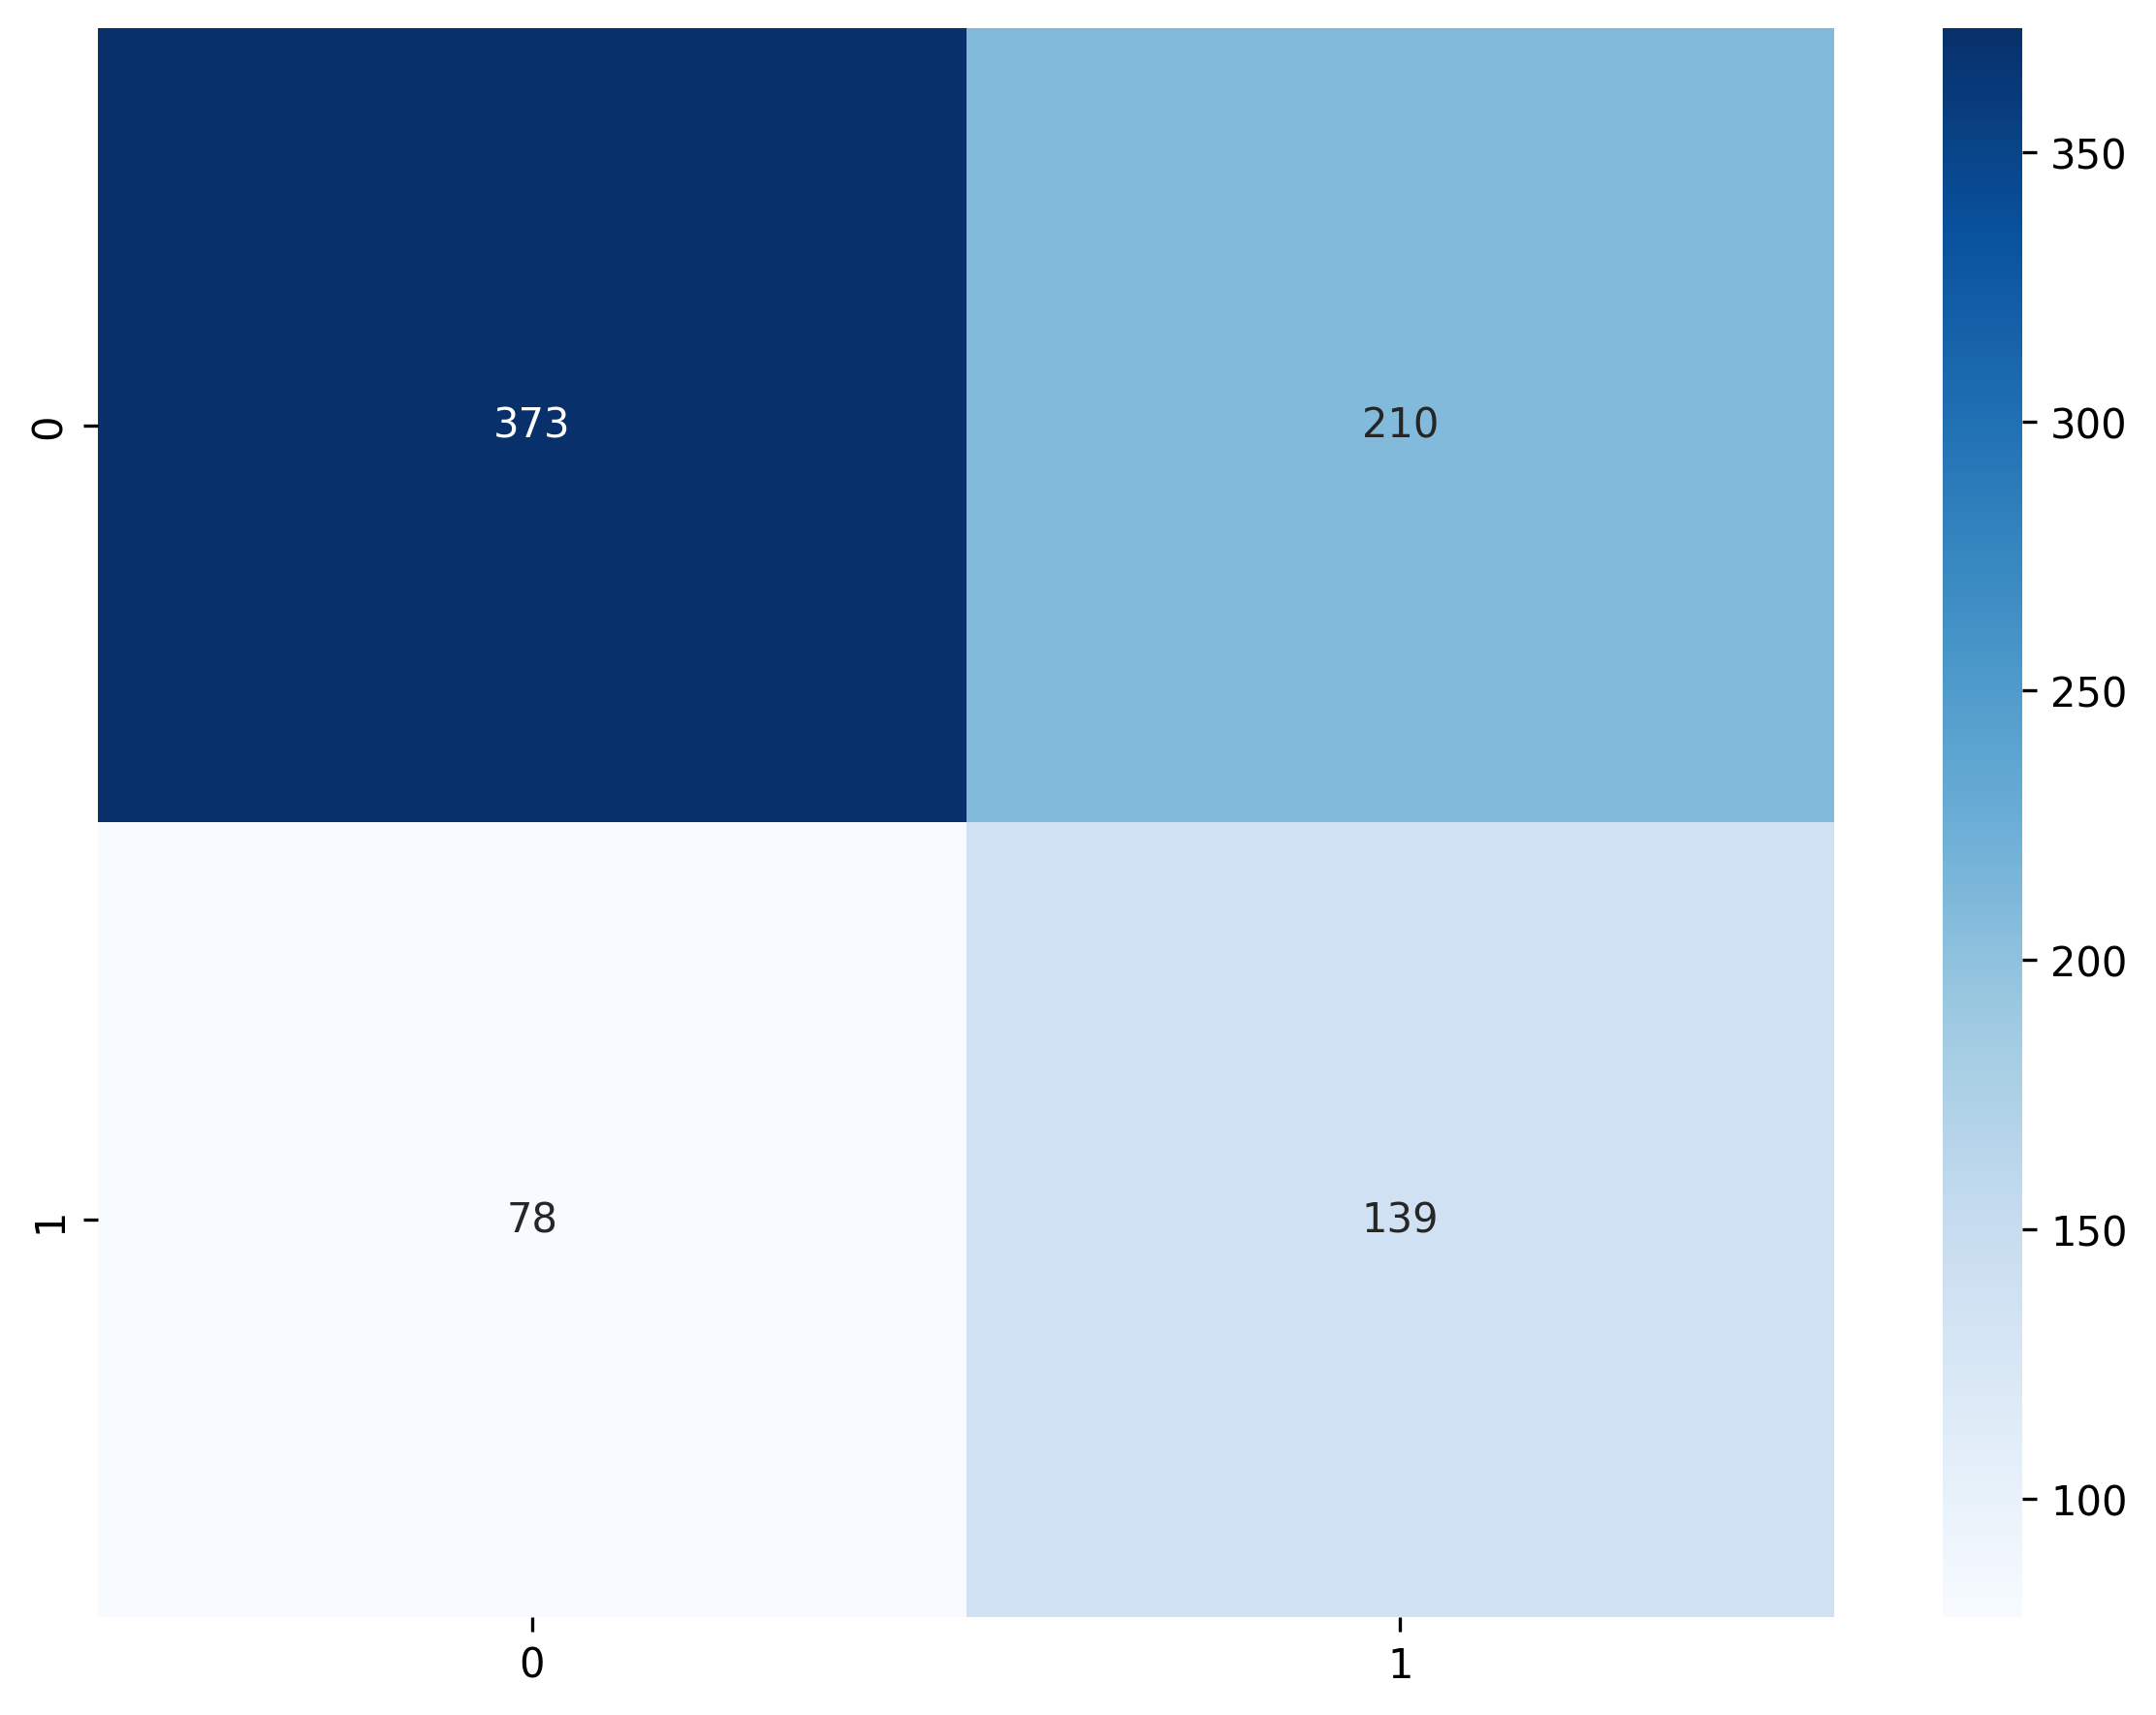

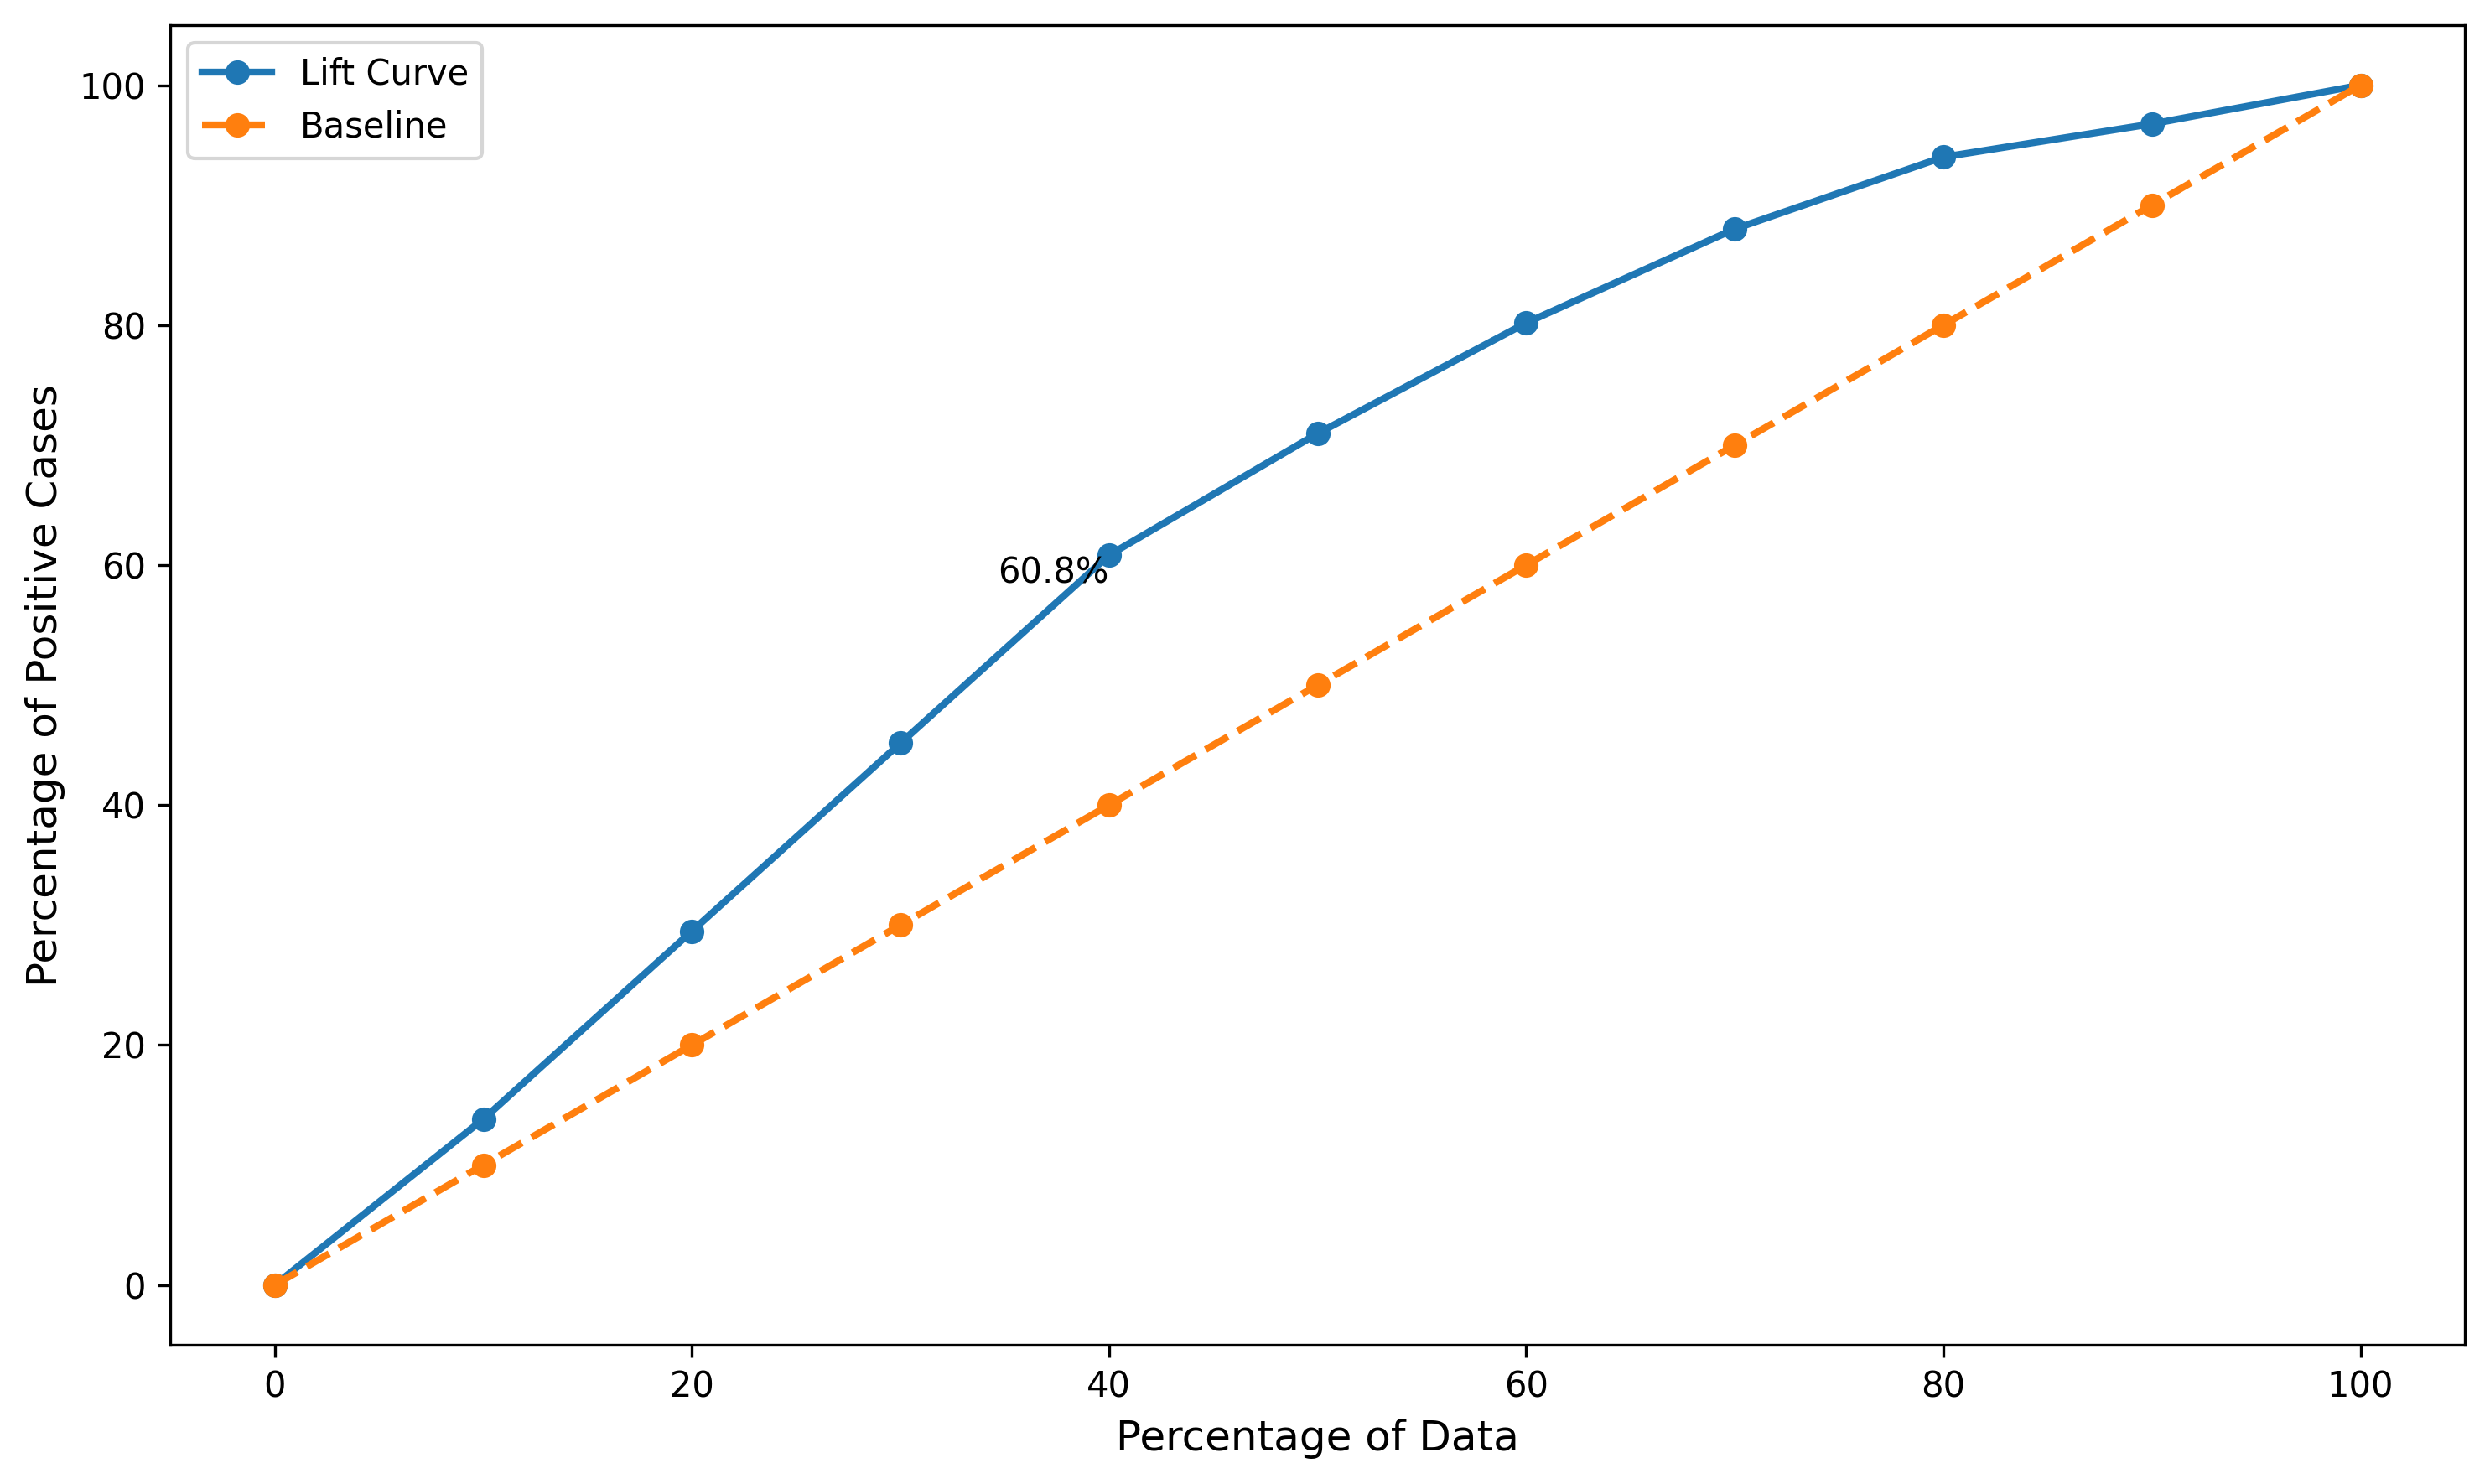

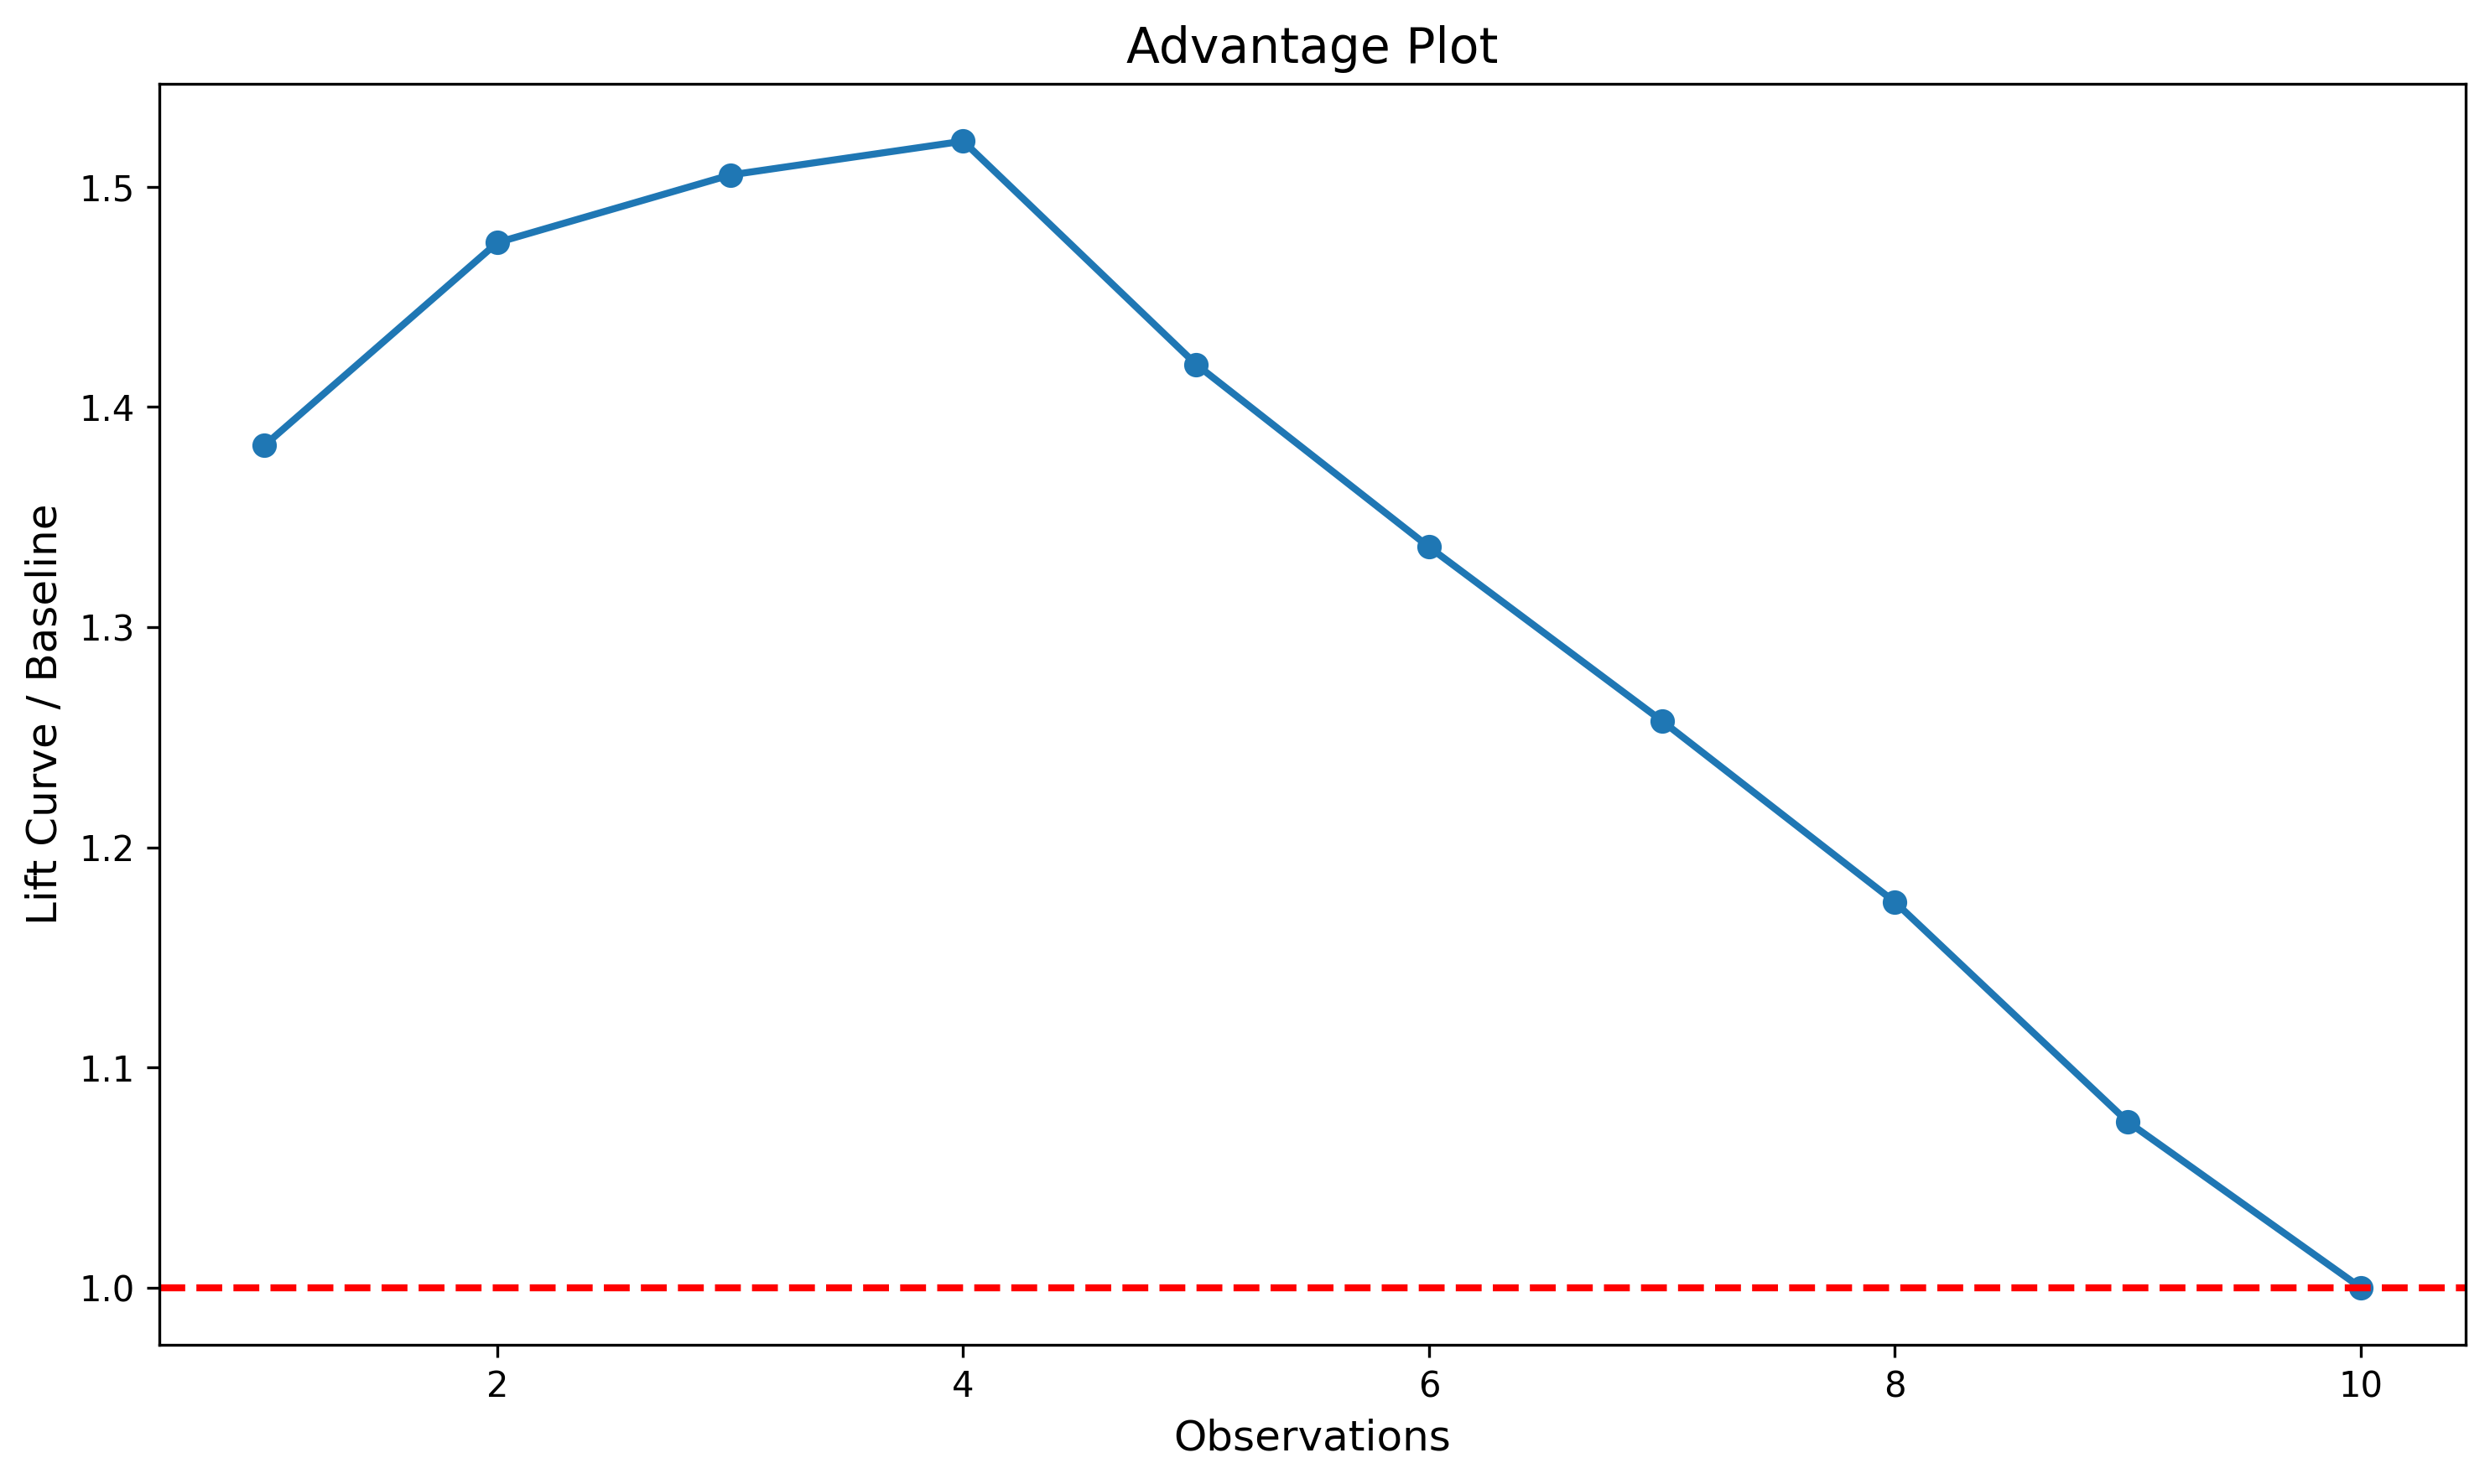

In [198]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations

base_features = ['age', 'dist', 'income', 'gender', 'marital_status']
interaction_terms = [
    ('age', 'dist'), ('age', 'income'), ('age', 'gender'), ('age', 'marital_status'),
    ('dist', 'income'), ('dist', 'gender'), ('dist', 'marital_status'),
    ('income', 'gender'), ('income', 'marital_status'), ('gender', 'marital_status')
]

results = []

for r in range(len(interaction_terms) + 1):
    for terms in combinations(interaction_terms, r):
        X = data[base_features].copy()
        
        for t1, t2 in terms:
            X[f'{t1}_{t2}'] = X[t1] * X[t2]
            
        y = data['target']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        model = sm.Logit(y_train, sm.add_constant(X_train)).fit(disp=0)
        y_pred_proba_test = model.predict(sm.add_constant(X_test))
        
        test_data = pd.DataFrame({'target': y_test, 'predicted_probs': y_pred_proba_test})
        test_data_sorted = test_data.sort_values('predicted_probs', ascending=False)
        
        total_pos = test_data_sorted['target'].sum()
        n_rows = len(test_data_sorted)
        cutoff_index = int(0.4 * n_rows)
        lift_at_40 = test_data_sorted.iloc[:cutoff_index]['target'].sum() / total_pos * 100
        
        results.append({
            'num_interactions': len(terms),
            'interactions': terms,
            'lift_at_40': lift_at_40
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('lift_at_40', ascending=False)
print("\nTop 10 interaction combinations by lift at 40%:")
print(results_df.head(10))

print("\nBest interaction combination:")
print(f"Number of interactions: {results_df.iloc[0]['num_interactions']}")
print(f"Interaction terms: {results_df.iloc[0]['interactions']}")
print(f"Lift at 40%: {results_df.iloc[0]['lift_at_40']:.2f}")

best_combo = results_df.iloc[0]
X = data[base_features].copy()
for t1, t2 in best_combo['interactions']:
    X[f'{t1}_{t2}'] = X[t1] * X[t2]

y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = sm.Logit(y_train, sm.add_constant(X_train)).fit()
y_pred_proba = model.predict(sm.add_constant(X_test))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
optimal_threshold = thresholds[np.argmin(np.abs(tpr - (1-fpr)))]
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {auc(fpr, tpr):.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.legend(fontsize=10)
ax1.tick_params(labelsize=10)

ax2.plot(thresholds, tpr, label='Sensitivity', color='green', lw=2)
ax2.plot(thresholds, 1-fpr, label='Specificity', color='red', lw=2)
ax2.axvline(x=optimal_threshold, color='black', linestyle='--', lw=2)
ax2.legend(fontsize=10)
ax2.tick_params(labelsize=10)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_optimal), annot=True, fmt='d', cmap='Blues')
plt.tick_params(labelsize=10)
plt.tight_layout()
plt.show()

test_data = pd.DataFrame({'target': y_test, 'predicted_probs': y_pred_proba})
test_data_sorted = test_data.sort_values('predicted_probs', ascending=False)

total_pos = test_data_sorted['target'].sum()
n_rows = len(test_data_sorted)
deciles = np.linspace(0, n_rows, 11, dtype=int)
lift_curve = [test_data_sorted.iloc[:i]['target'].sum() / total_pos * 100 for i in deciles]
baseline = np.linspace(0, 100, 11)

plt.figure(figsize=(10, 6))
plt.plot(baseline, lift_curve, label='Lift Curve', marker='o', lw=2)
plt.plot(baseline, baseline, label='Baseline', linestyle='--', marker='o', lw=2)
plt.xlabel('Percentage of Data', fontsize=12)
plt.ylabel('Percentage of Positive Cases', fontsize=12)
plt.legend(fontsize=10)
plt.tick_params(labelsize=10)
lift_at_40_index = 4  # Index for 40% in deciles
plt.text(40, lift_curve[lift_at_40_index], f'{lift_curve[lift_at_40_index]:.1f}%', 
         horizontalalignment='right', verticalalignment='top')
plt.tight_layout()
plt.show()

lift_data = pd.DataFrame({
    'Lift Curve': lift_curve,
    'Baseline': baseline
})

plt.figure(figsize=(10, 6))
plt.plot(range(11), lift_data['Lift Curve'] / lift_data['Baseline'], marker='o', lw=2)
plt.axhline(y=1, color='r', linestyle='--', lw=2)
plt.xlabel('Observations', fontsize=12)
plt.ylabel('Lift Curve / Baseline', fontsize=12)
plt.title('Advantage Plot', fontsize=14)
plt.tick_params(labelsize=10)
plt.tight_layout()
plt.show()

61.8 % is the best possible yield of responses from contacting 40% of the potential customers from testing every possible combination of interaction terms.

# Evaluate Random Forest

Training Accuracy: 0.973
Testing Accuracy: 0.680


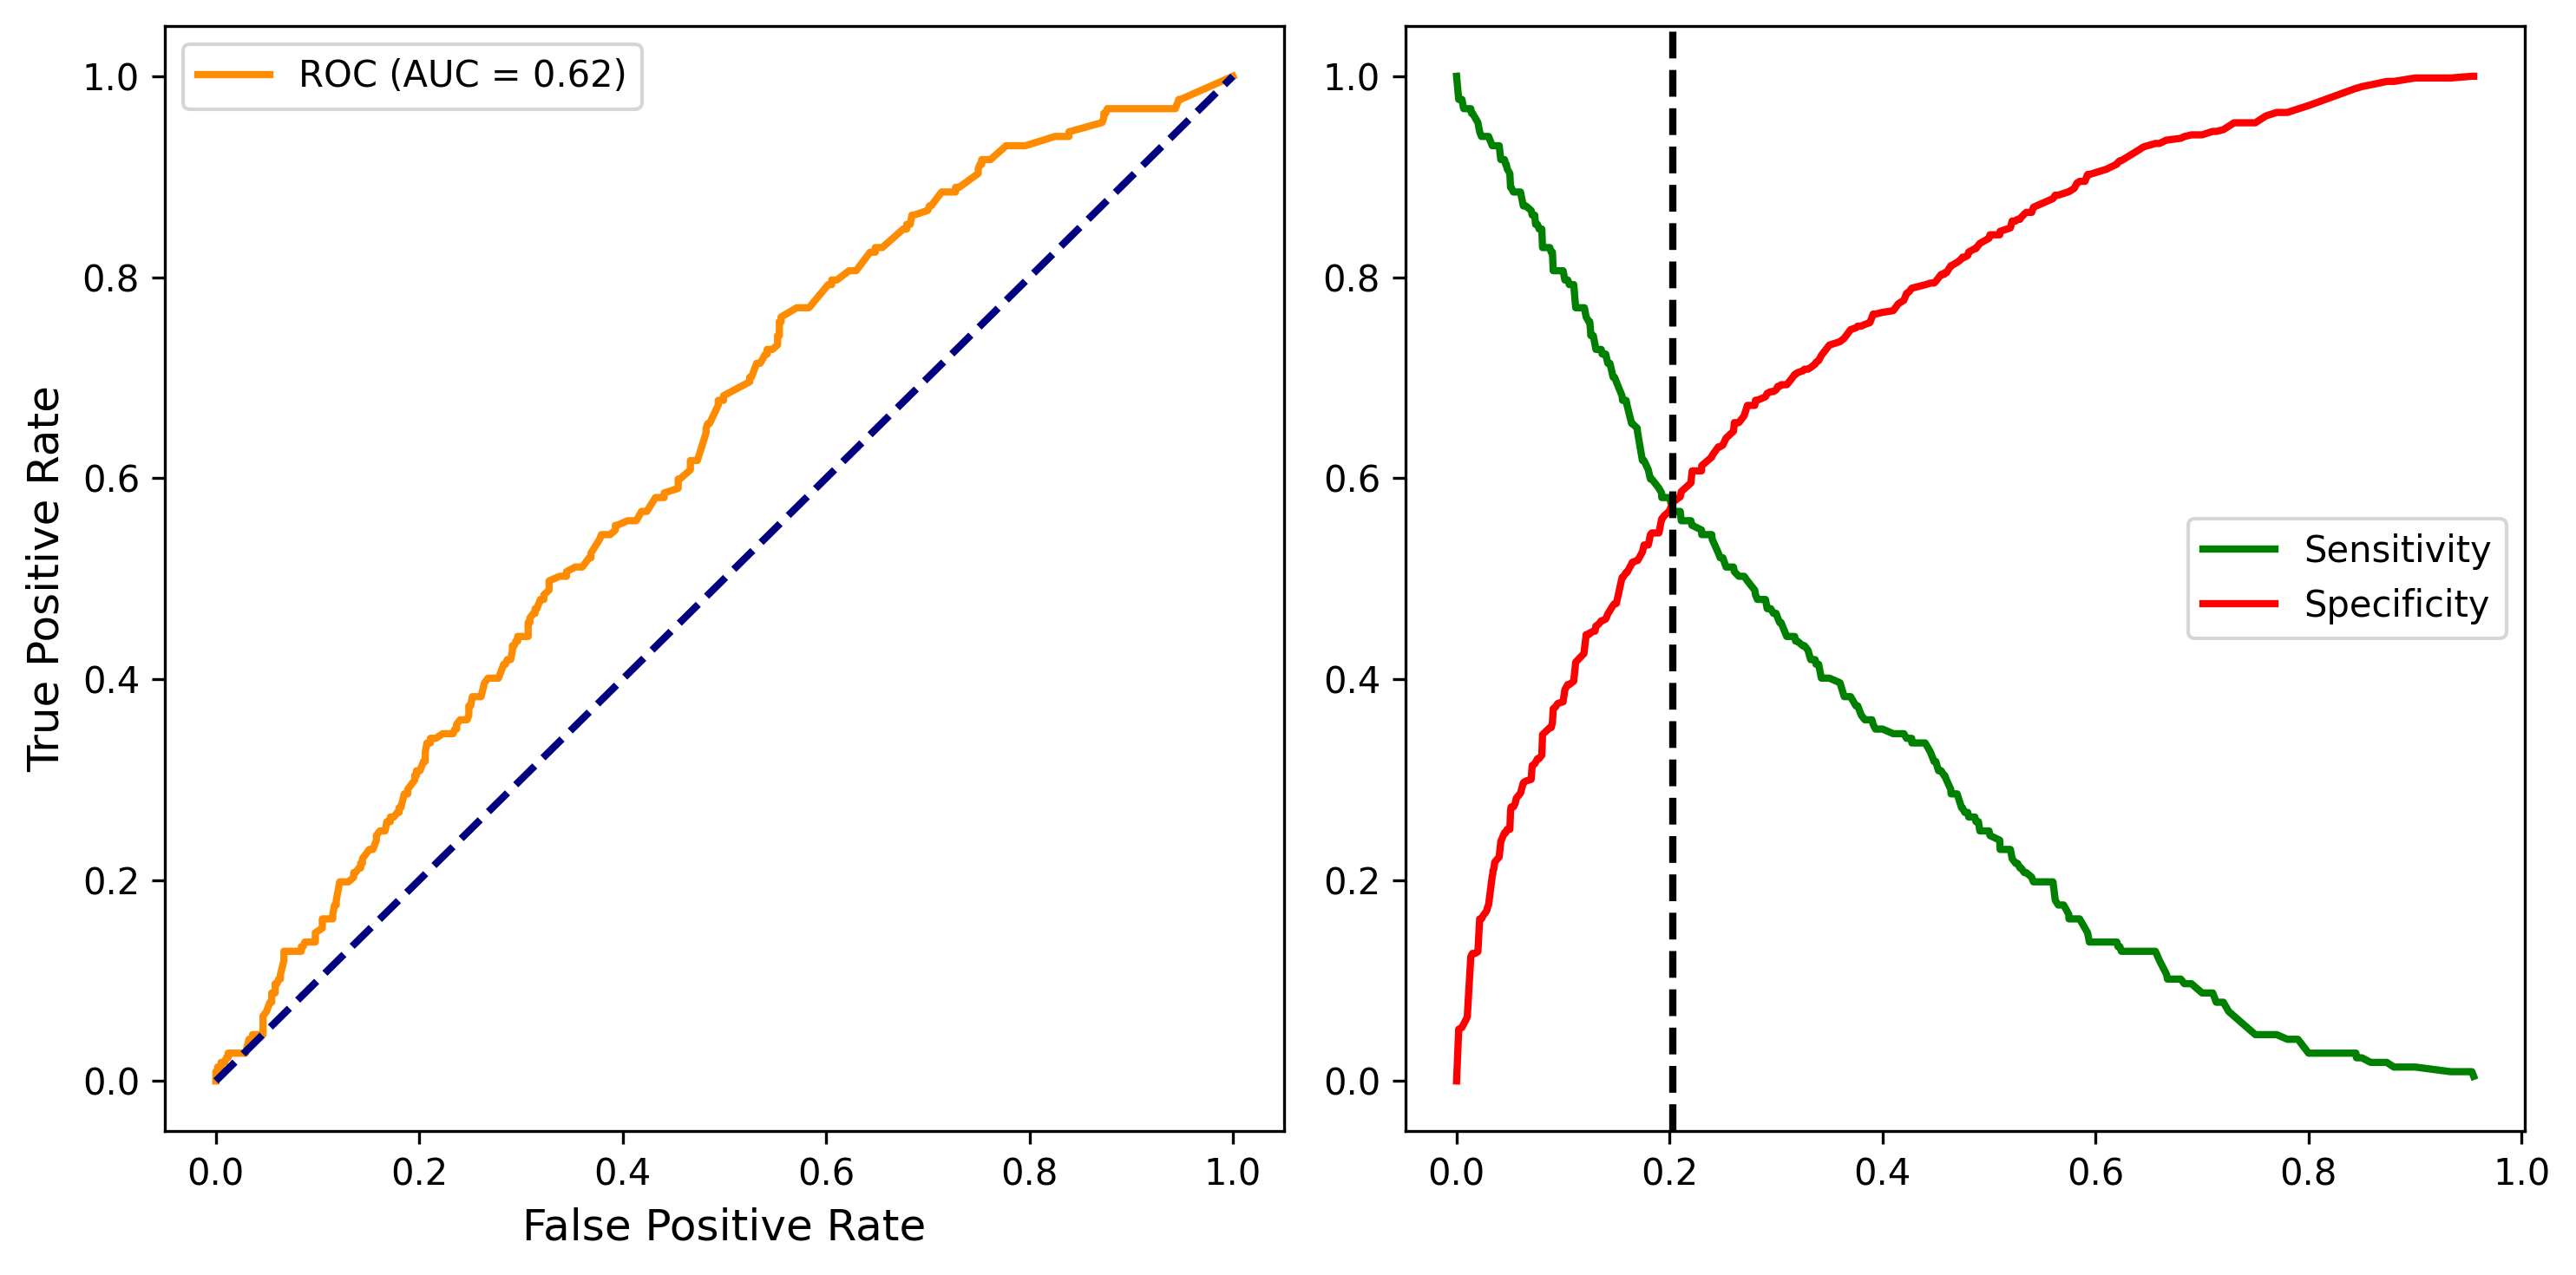

Optimal threshold: 0.203
Sensitivity: 0.567
Specificity: 0.576


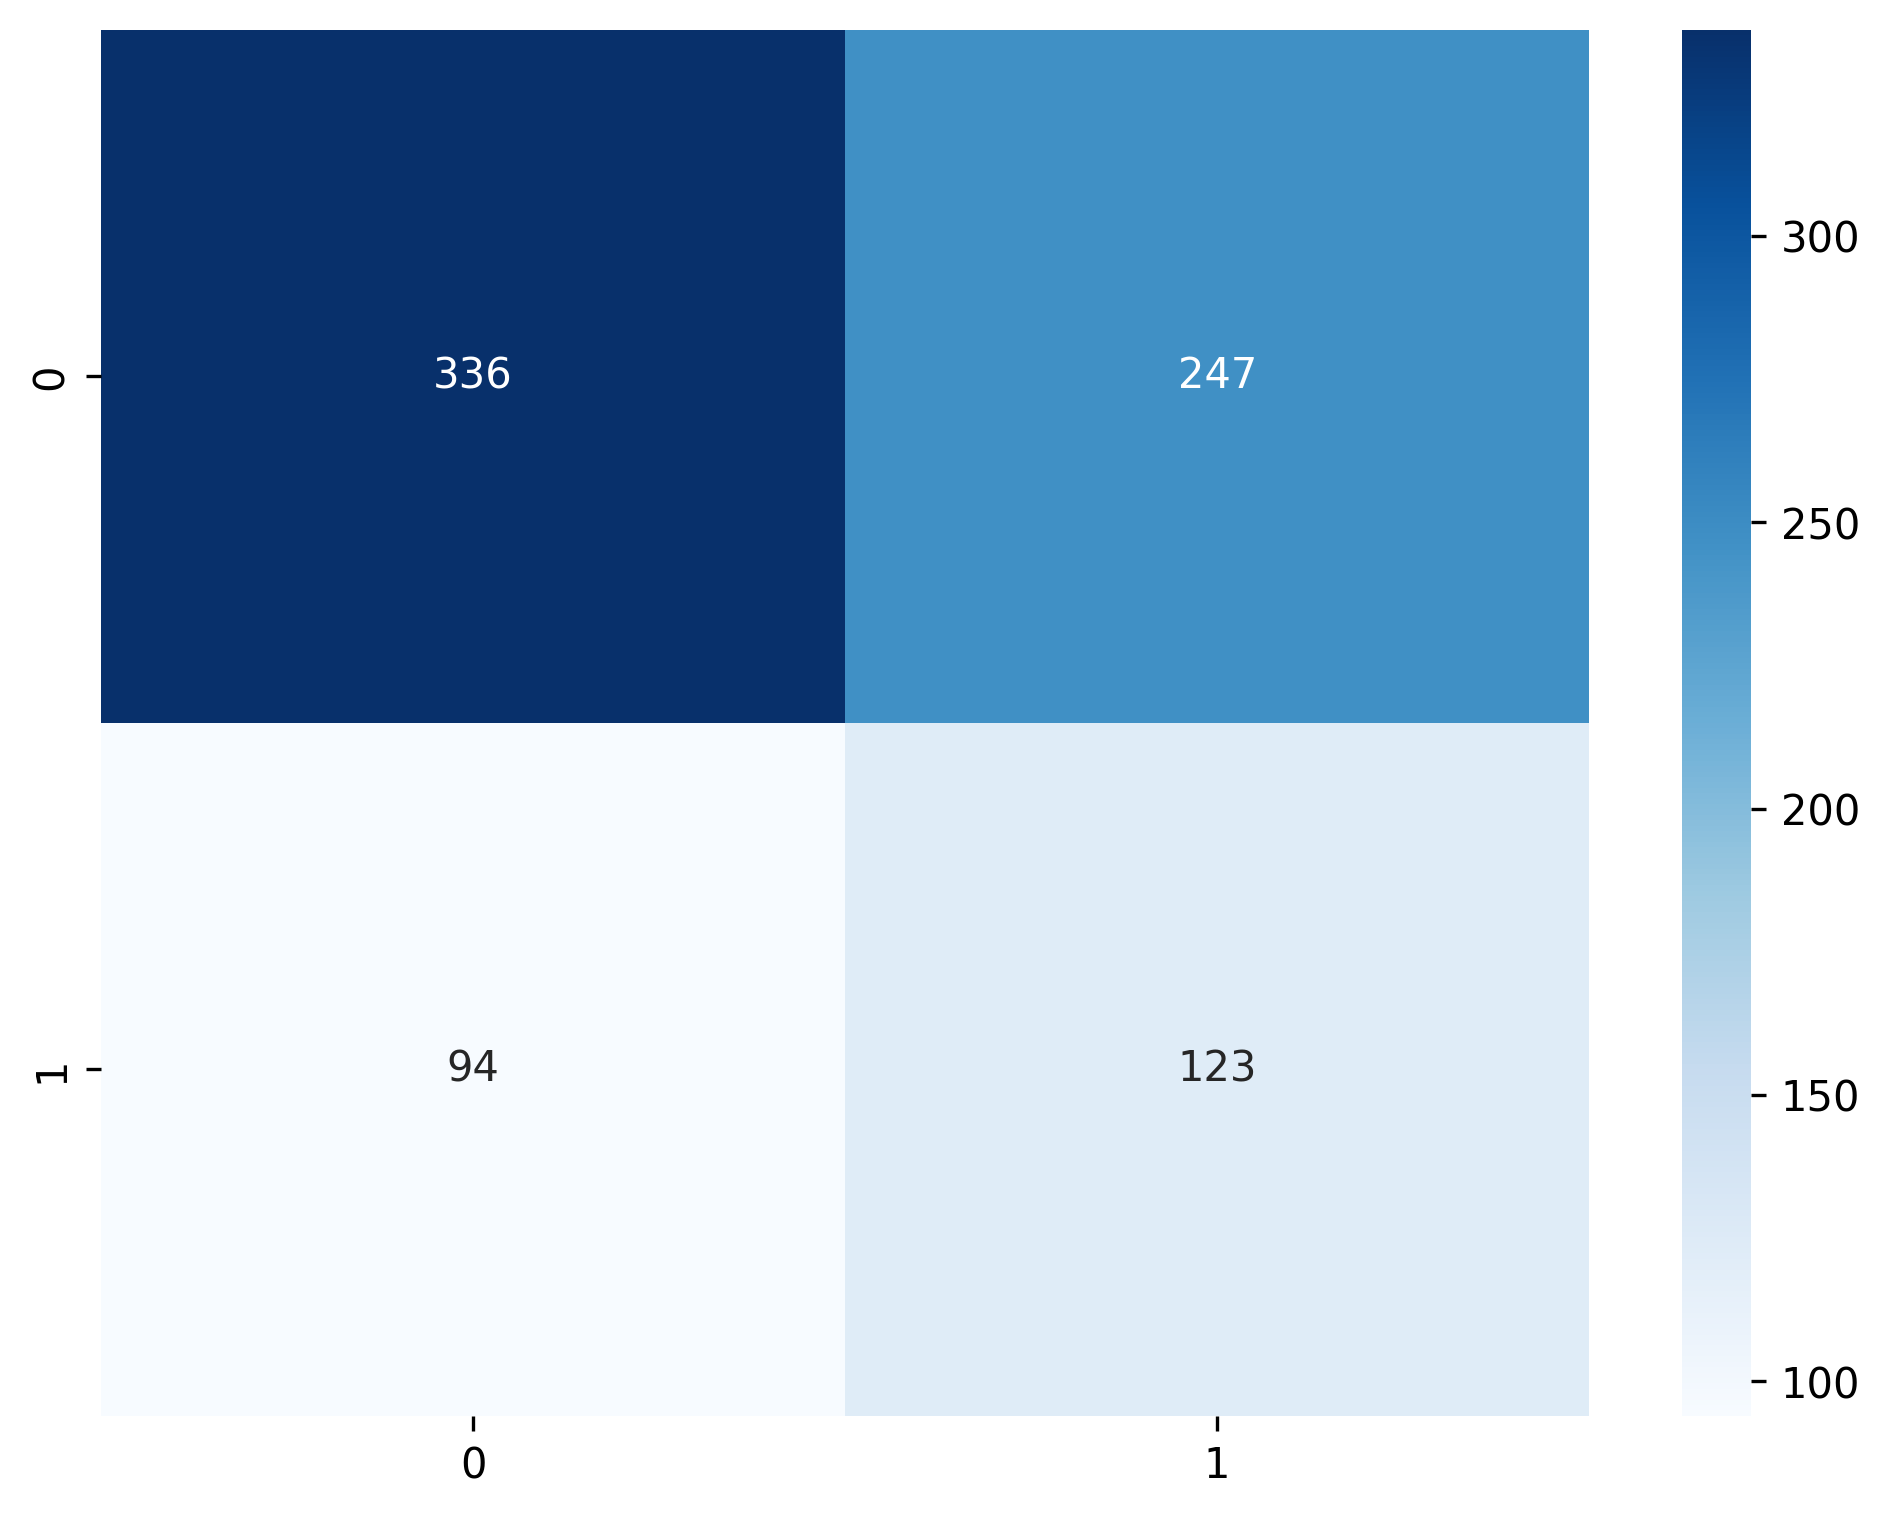

    Lift Curve  Baseline
0     0.000000         0
1    13.824885        10
2    26.267281        20
3    39.631336        30
4    51.152074        40
5    60.368664        50
6    73.271889        60
7    82.949309        70
8    91.705069        80
9    96.313364        90
10  100.000000       100


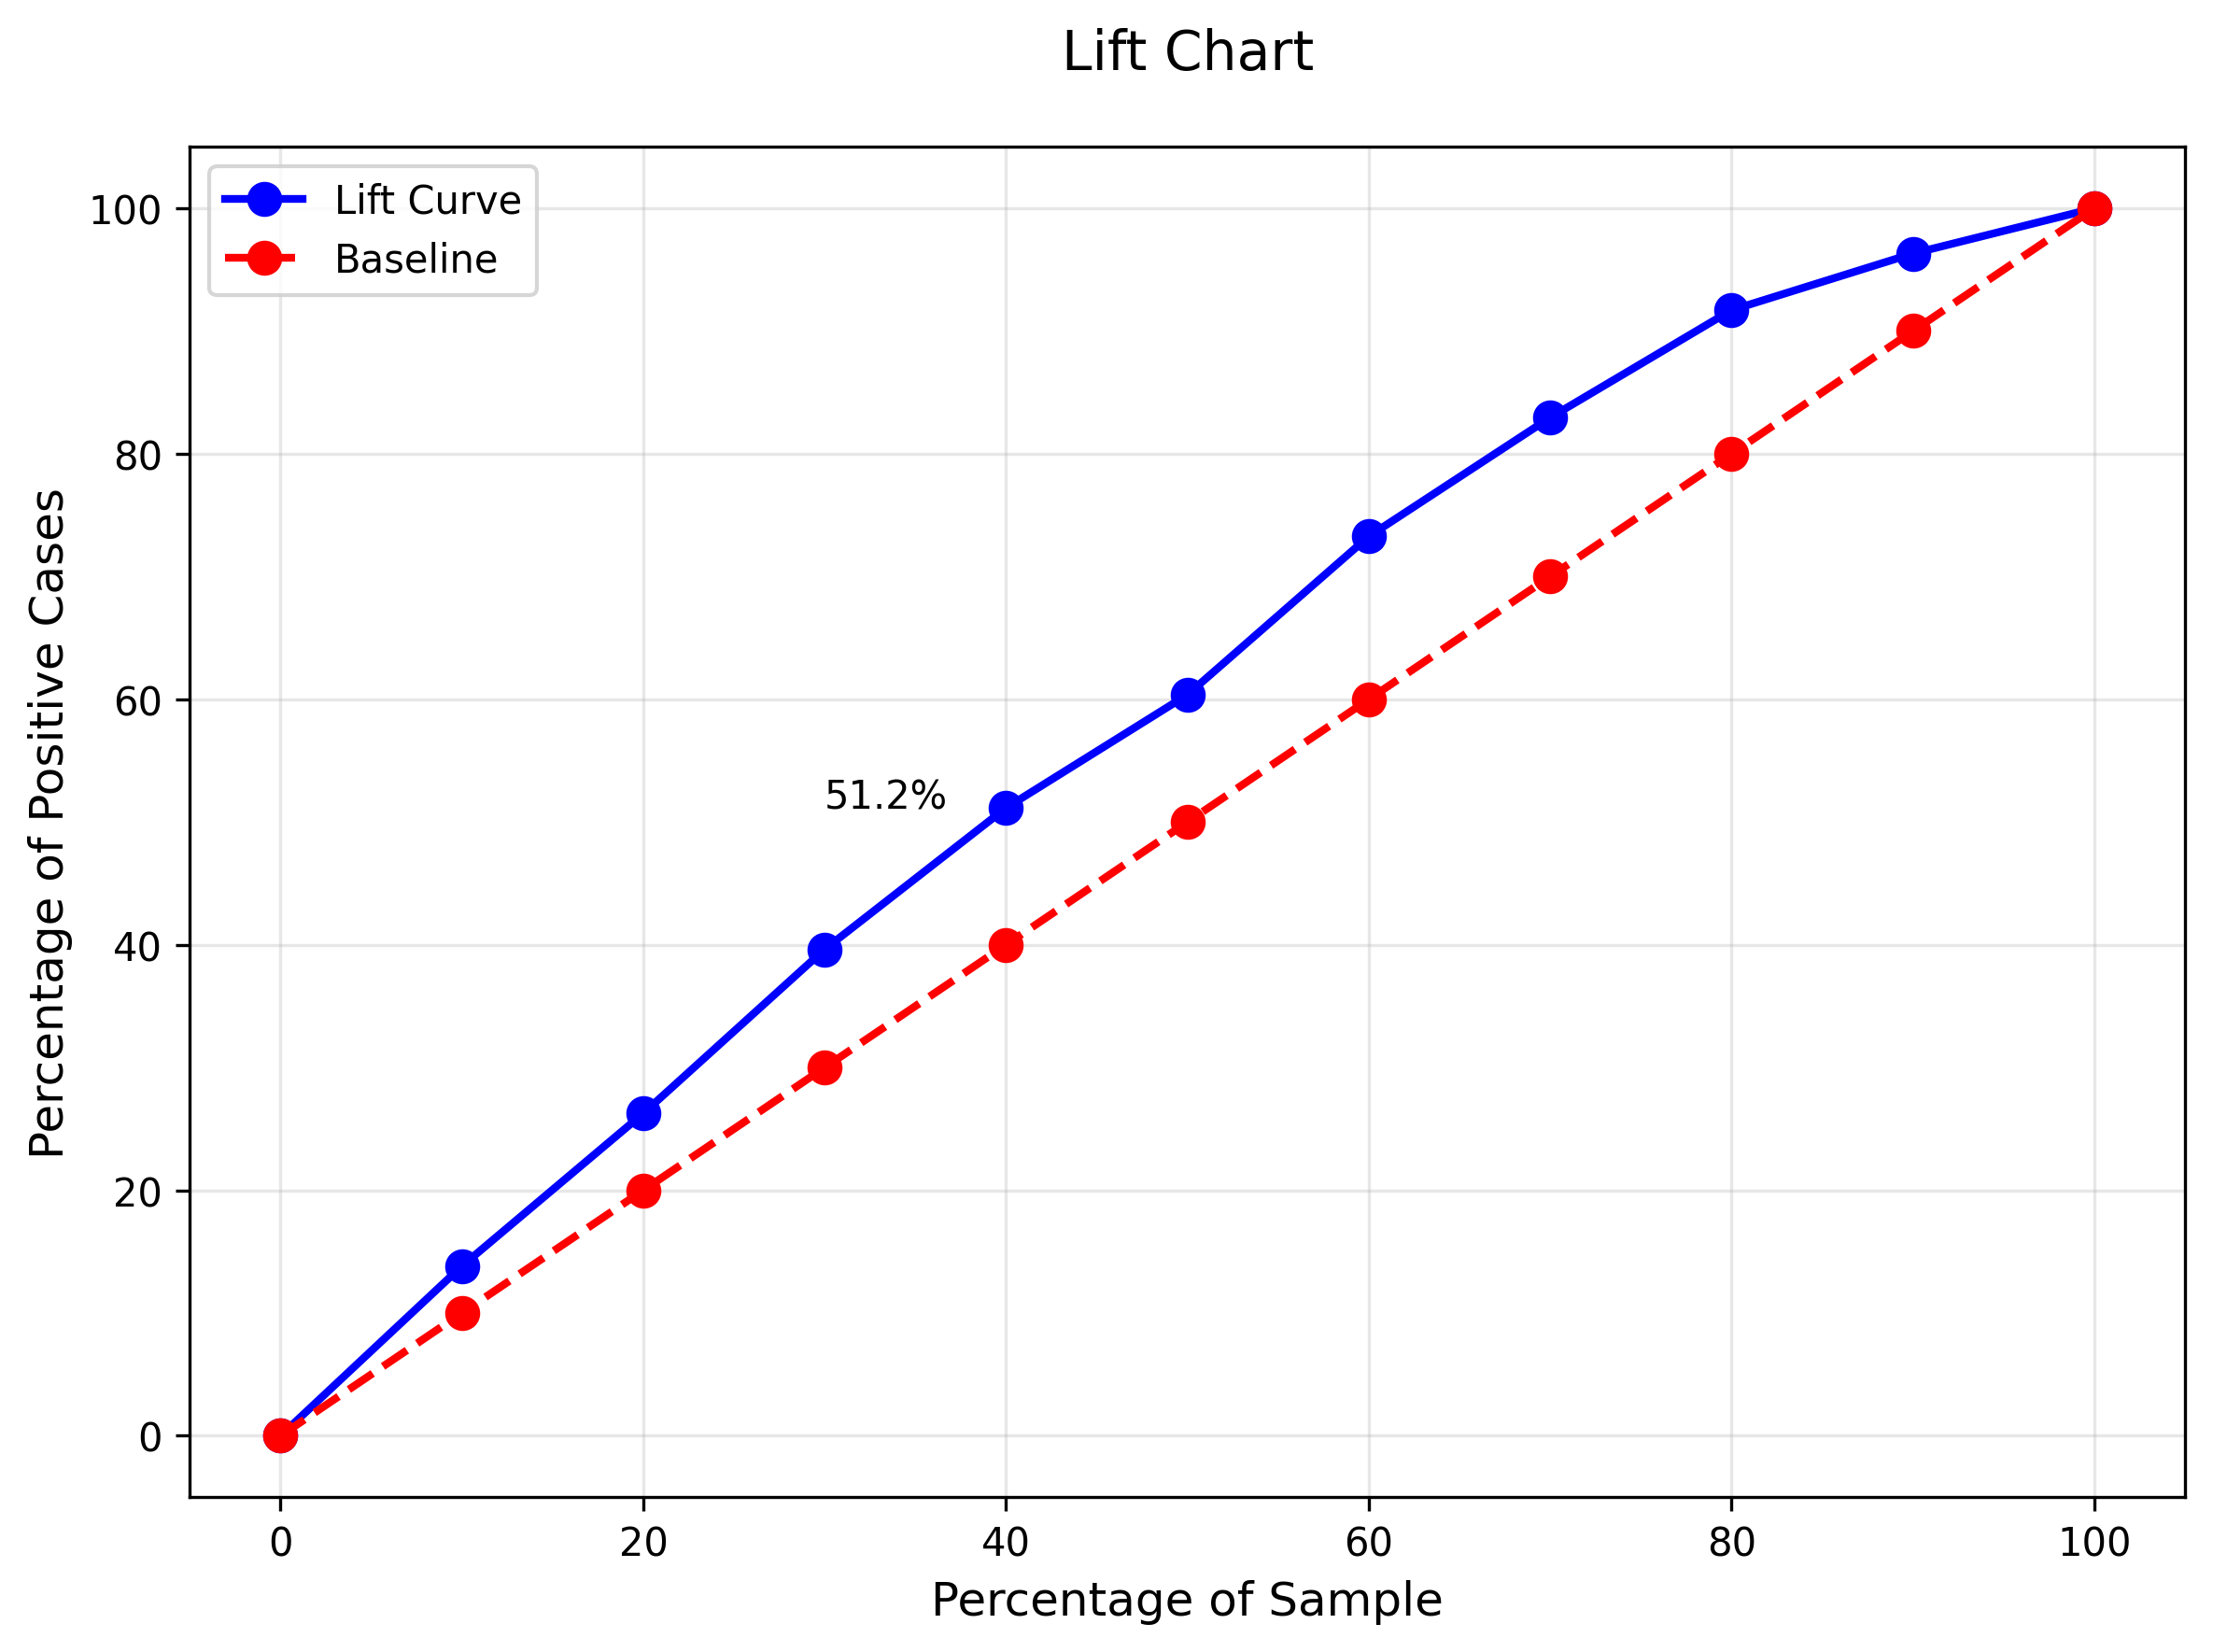

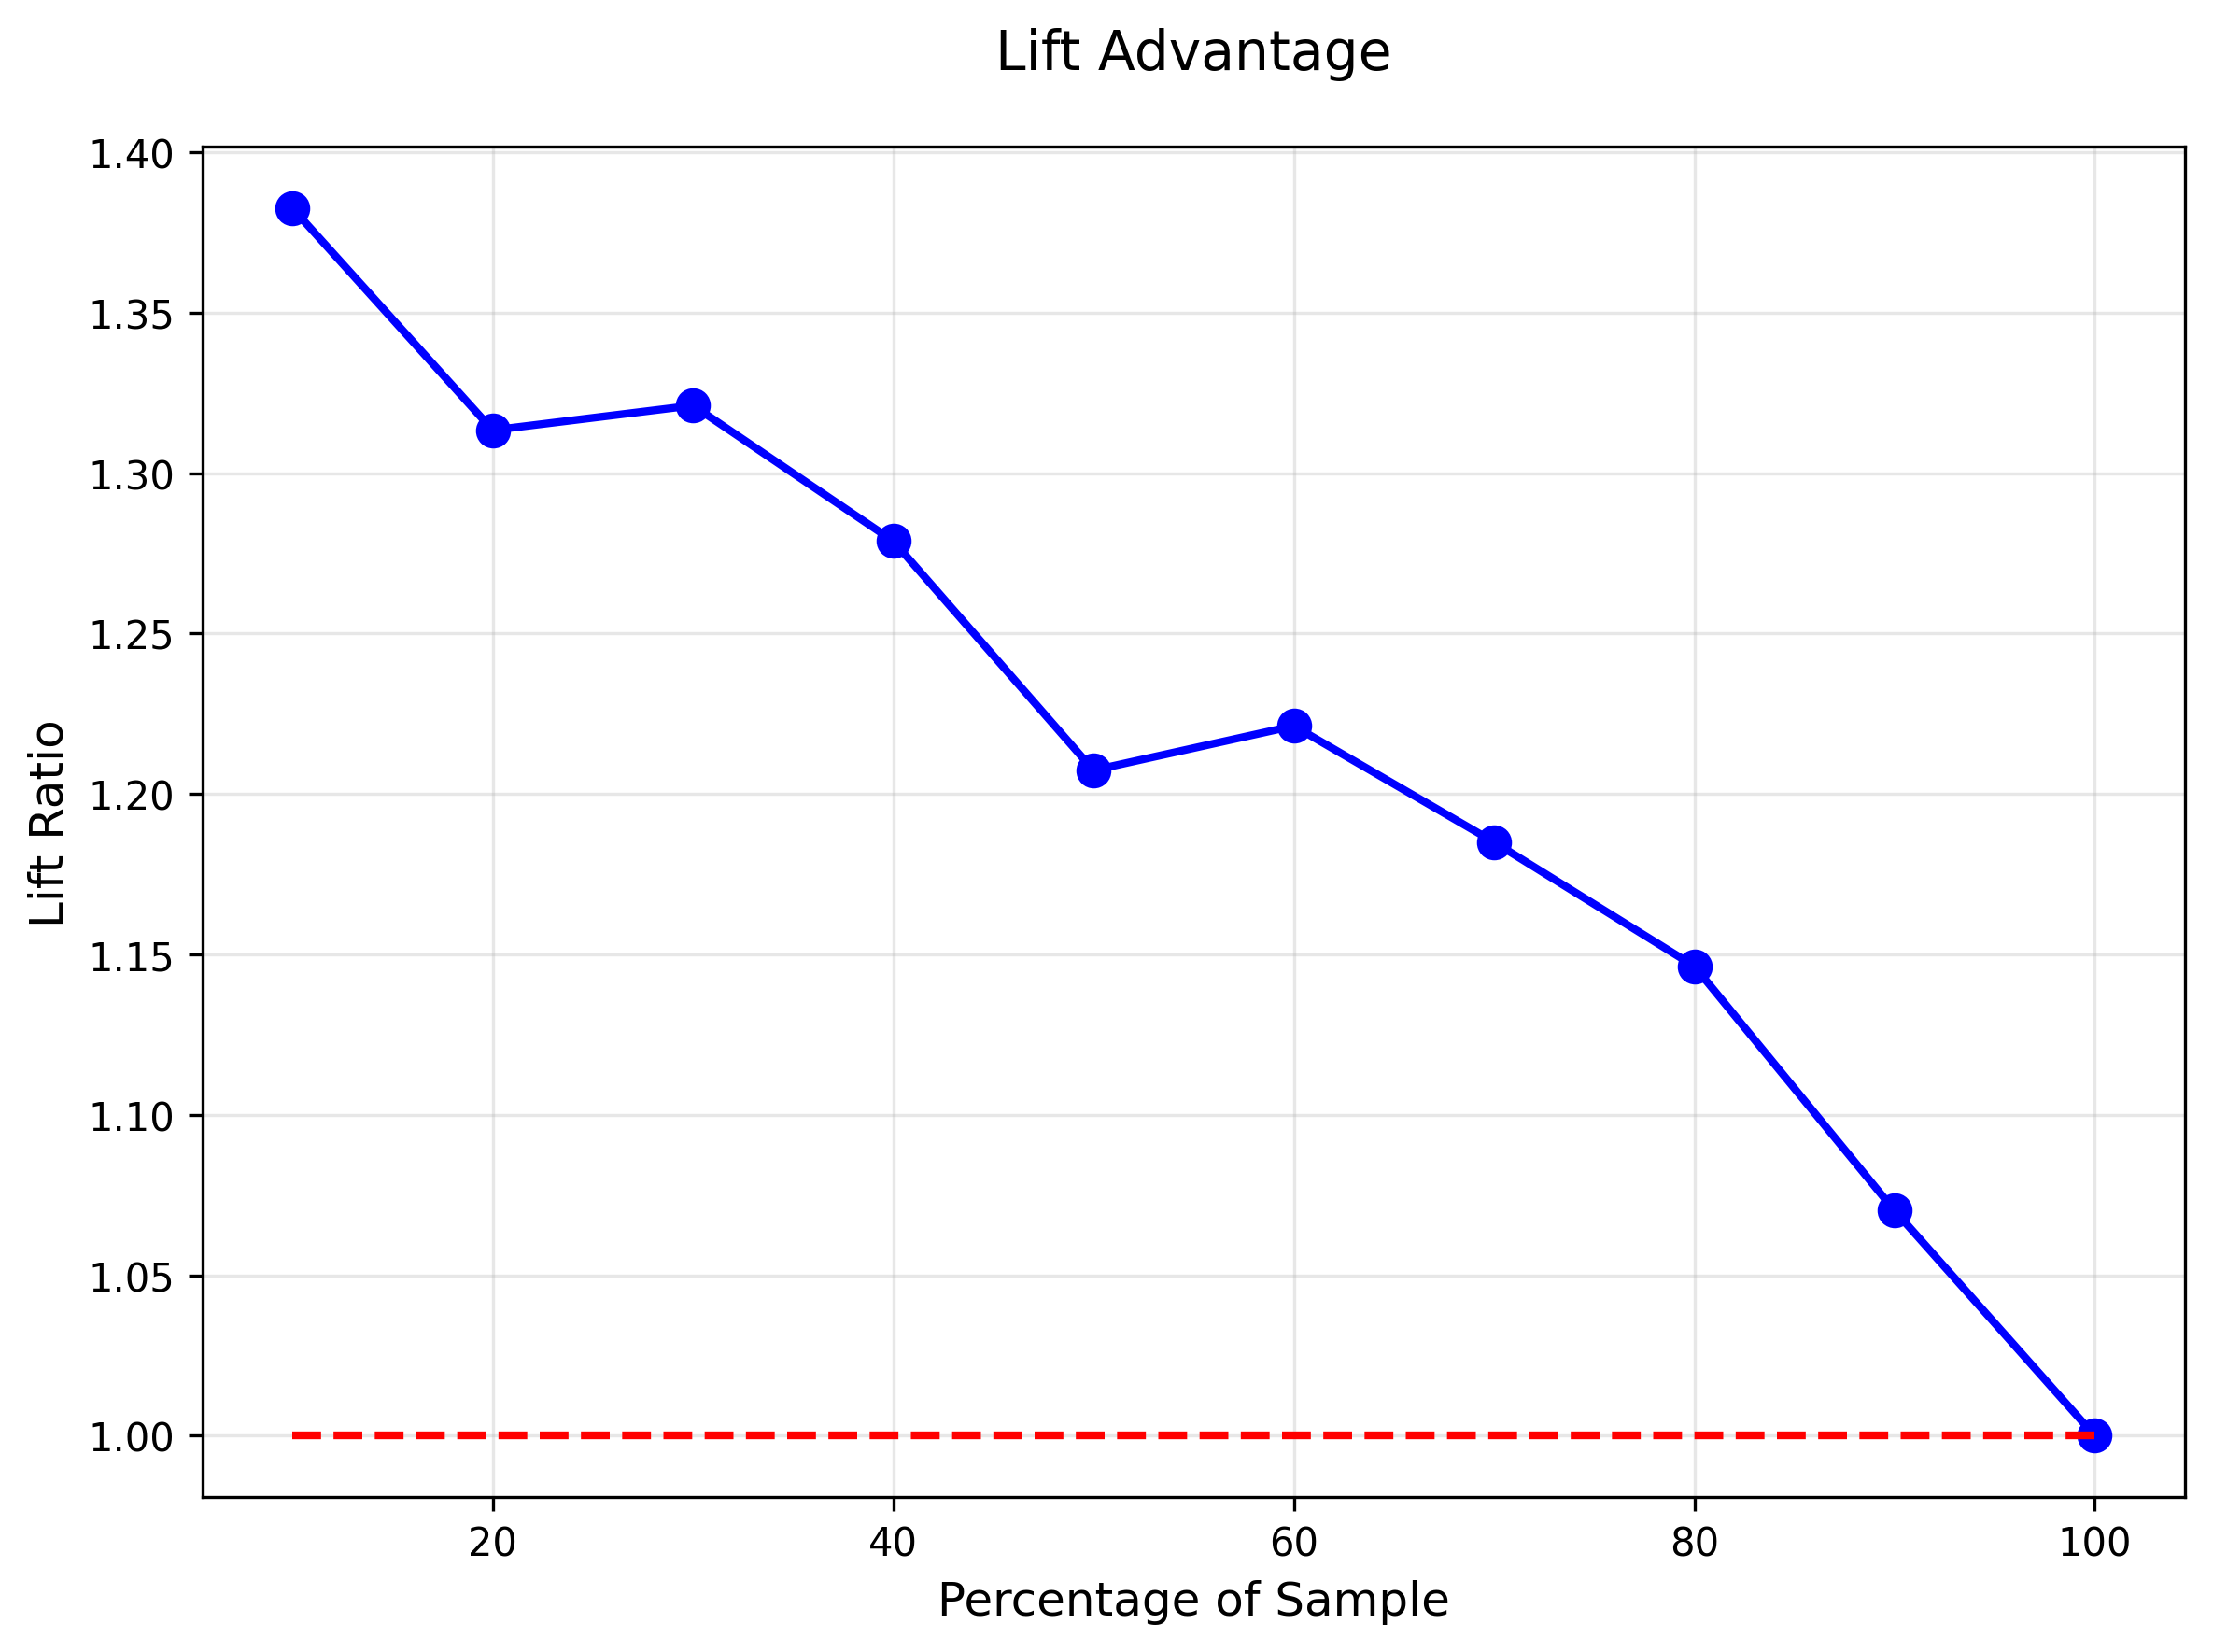

      target  predicted_probs
2643       1         0.955000
1091       1         0.953333
156        0         0.933333
2561       1         0.900000
3962       0         0.880000
      target  predicted_probs
2335       0         0.000000
3722       0         0.010000
3379       0         0.845000
2313       0         0.090714
3782       0         0.086667


In [199]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

X = data[['age', 'dist', 'income', 'gender', 'marital_status']]
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print(f"Training Accuracy: {rf_model.score(X_train, y_train):.3f}")
print(f"Testing Accuracy: {rf_model.score(X_test, y_test):.3f}")

y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
optimal_threshold = thresholds[np.argmin(np.abs(tpr - (1-fpr)))]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {auc(fpr, tpr):.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.legend(fontsize=10)
ax1.tick_params(labelsize=10)

ax2.plot(thresholds, tpr, label='Sensitivity', color='green', lw=2)
ax2.plot(thresholds, 1-fpr, label='Specificity', color='red', lw=2)
ax2.axvline(x=optimal_threshold, color='black', linestyle='--', lw=2)
ax2.legend(fontsize=10)
ax2.tick_params(labelsize=10)
plt.tight_layout()
plt.show()

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Sensitivity: {tpr[np.argmin(np.abs(tpr - (1-fpr)))]:.3f}")
print(f"Specificity: {1-fpr[np.argmin(np.abs(tpr - (1-fpr)))]:.3f}")

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, (y_pred_proba >= optimal_threshold).astype(int)), annot=True, fmt='d', cmap='Blues')
plt.show()

test_data = pd.DataFrame({'target': y_test, 'predicted_probs': y_pred_proba})
test_data_sorted = test_data.sort_values(by='predicted_probs', ascending=False)
total_positives = test_data_sorted['target'].sum()
n_rows = len(test_data_sorted)

lift_curve = [(test_data_sorted.iloc[:int((i/10)*n_rows)]['target'].sum() / total_positives * 100) for i in range(11)]
baseline_curve = [i*10 for i in range(11)]
lift_data = pd.DataFrame({'Lift Curve': lift_curve, 'Baseline': baseline_curve})
print(lift_data)

plt.figure(figsize=(8, 6))
plt.plot(range(0, 101, 10), lift_curve, label='Lift Curve', color='blue', marker='o', lw=2, markersize=8)
plt.plot(range(0, 101, 10), baseline_curve, label='Baseline', color='red', linestyle='--', marker='o', lw=2, markersize=8)
plt.text(30, lift_curve[4], f'{lift_curve[4]:.1f}%', fontsize=10)
plt.xlabel('Percentage of Sample', fontsize=12)
plt.ylabel('Percentage of Positive Cases', fontsize=12)
plt.title('Lift Chart', fontsize=14, pad=20)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tick_params(labelsize=10)
plt.tight_layout()
plt.show()

advantage_data = pd.DataFrame({'Lift': np.array(lift_curve[1:])/np.array(baseline_curve[1:])})
plt.figure(figsize=(8, 6))
plt.plot(range(10, 101, 10), advantage_data['Lift'], color='blue', marker='o', lw=2, markersize=8)
plt.plot(range(10, 101, 10), [1]*10, color='red', linestyle='--', lw=2)
plt.xlabel('Percentage of Sample', fontsize=12)
plt.ylabel('Lift Ratio', fontsize=12)
plt.title('Lift Advantage', fontsize=14, pad=20)
plt.grid(True, alpha=0.3)
plt.tick_params(labelsize=10)
plt.tight_layout()
plt.show()

print(test_data_sorted.head())
print(test_data.sample(frac=1, random_state=42).head())

The 

In [200]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_full_pairplot_with_corr_binary_target(df, continuous_vars, target_var='target', positive_value=1, negative_value=0):
    pairplot_data = df[continuous_vars + [target_var]].copy()
    pairplot_data[target_var] = pairplot_data[target_var].astype('category')
    correlation_matrix = pairplot_data[continuous_vars].corr()
    g = sns.pairplot(pairplot_data, hue=target_var, palette={positive_value: 'green', negative_value: 'red'}, diag_kind='kde', corner=False)
    for i, row_var in enumerate(continuous_vars):
        for j, col_var in enumerate(continuous_vars):
            if i != j:
                g.axes[i, j].annotate(f"Corr: {correlation_matrix.loc[row_var, col_var]:.2f}", xy=(0.5, 0.1), xycoords="axes fraction", ha="center", fontsize=9, color="blue")
    plt.suptitle(f"Full Pair Plot for Predictors Colored by '{target_var}'", y=1.02, fontsize=16)
    plt.show()

plot_full_pairplot_with_corr_binary_target(data, ['age', 'dist', 'income', 'marital_status', 'gender'], 'target')

In [183]:
print(data.head(1))

   id  age  dist  income  gender  marital_status  target
0   1   73     4      10       1               0       1


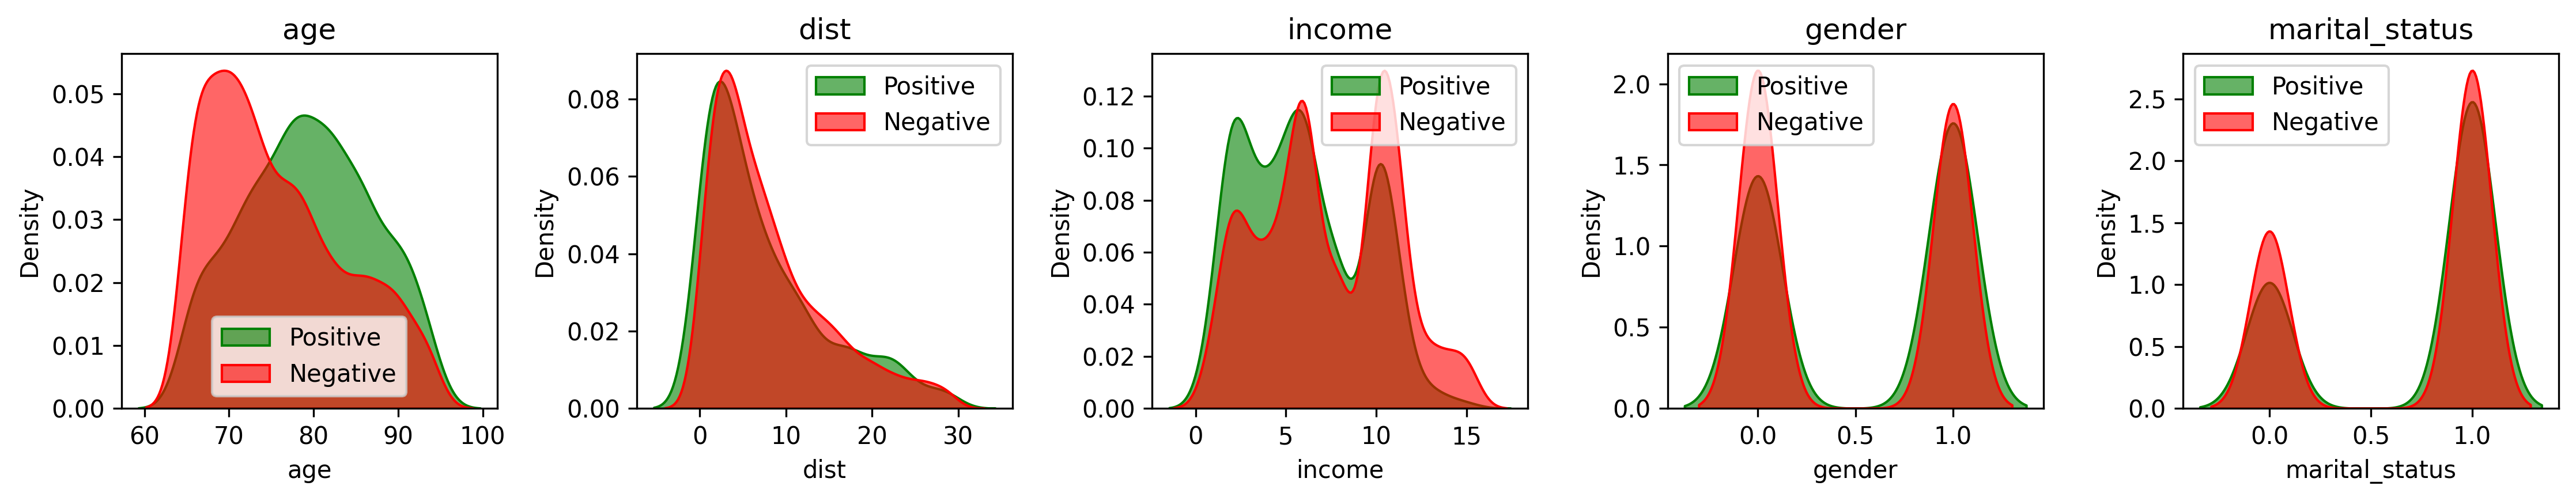

In [184]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
variables = ['age', 'dist', 'income', 'gender', 'marital_status']

for i, var in enumerate(variables):
    sns.kdeplot(data=data[data['target'] == 1], x=var, ax=axes[i], 
                fill=True, alpha=0.6, label='Positive', color='green')
    sns.kdeplot(data=data[data['target'] == 0], x=var, ax=axes[i],
                fill=True, alpha=0.6, label='Negative', color='red')
    axes[i].set_title(var)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [185]:
print(data.head(1))

   id  age  dist  income  gender  marital_status  target
0   1   73     4      10       1               0       1


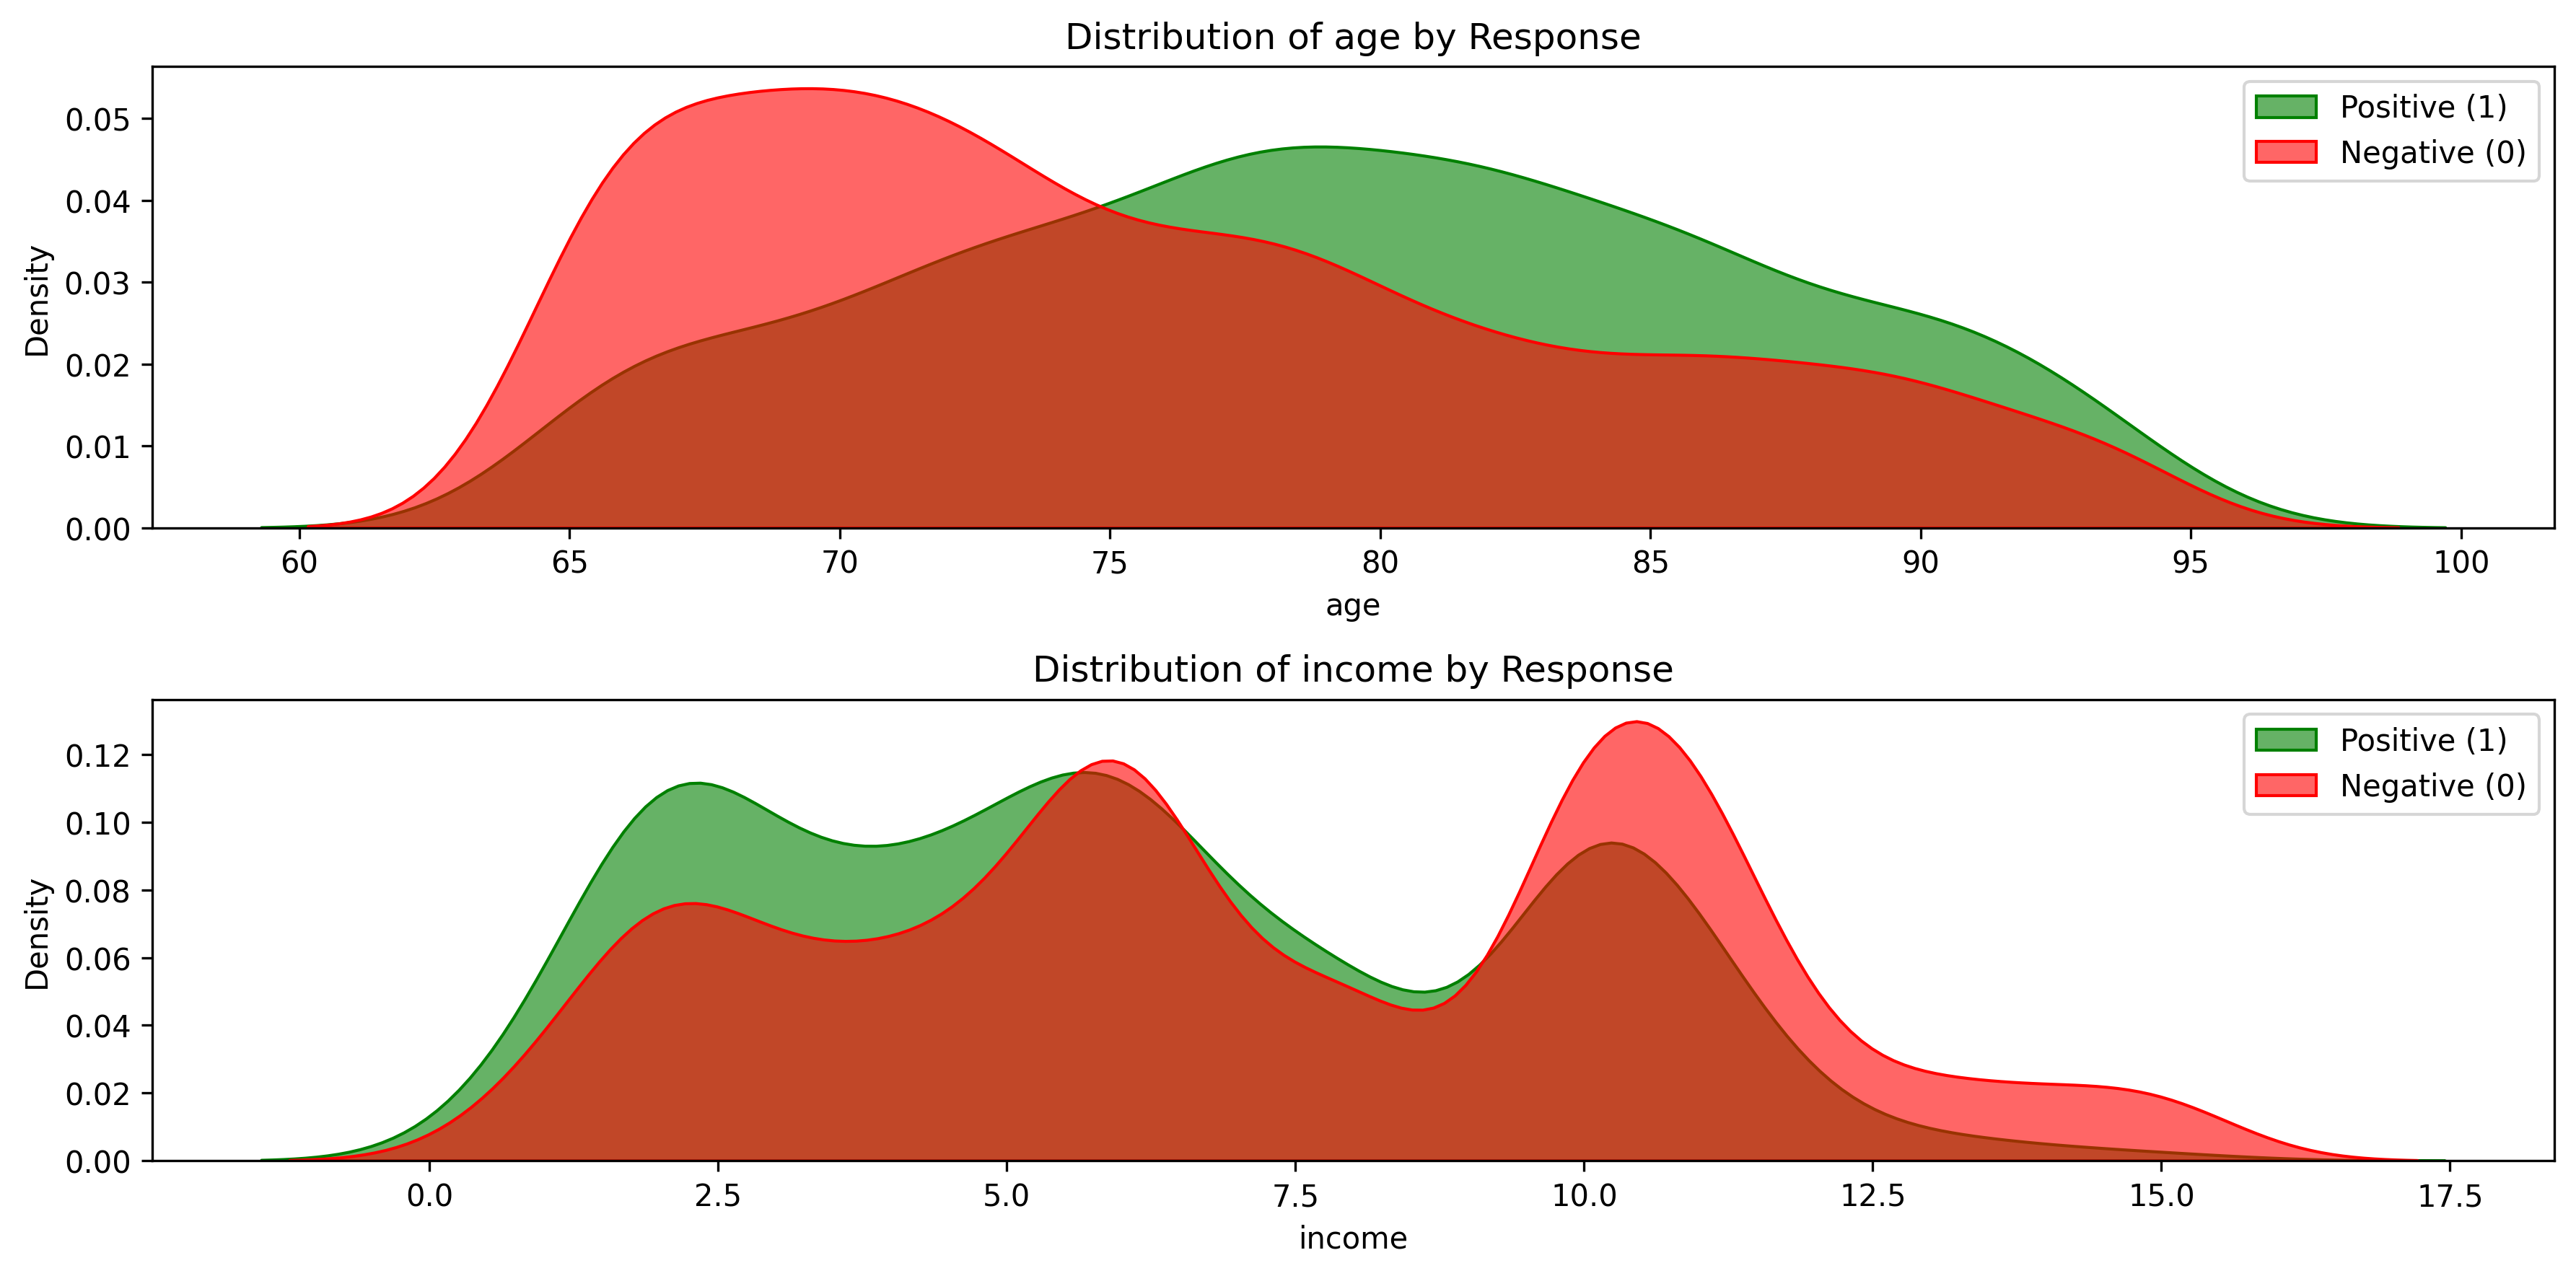

In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def ridge_plot_by_response(df, variables, categorical_var='target', positive_value=1, negative_value=0):
    plt.figure(figsize=(12, 6))
    
    for i, var in enumerate(variables):
        plt.subplot(2, 1, i + 1)
        
        sns.kdeplot(data=df[df[categorical_var] == positive_value], x=var, 
                    fill=True, alpha=0.6, label=f'Positive ({positive_value})', color='green')
        
        sns.kdeplot(data=df[df[categorical_var] == negative_value], x=var, 
                    fill=True, alpha=0.6, label=f'Negative ({negative_value})', color='red')
        
        plt.title(f'Distribution of {var} by Response')
        plt.xlabel(var)
        plt.ylabel('Density')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

variables = ['age', 'income']
ridge_plot_by_response(data, variables, categorical_var='target', positive_value=1, negative_value=0)

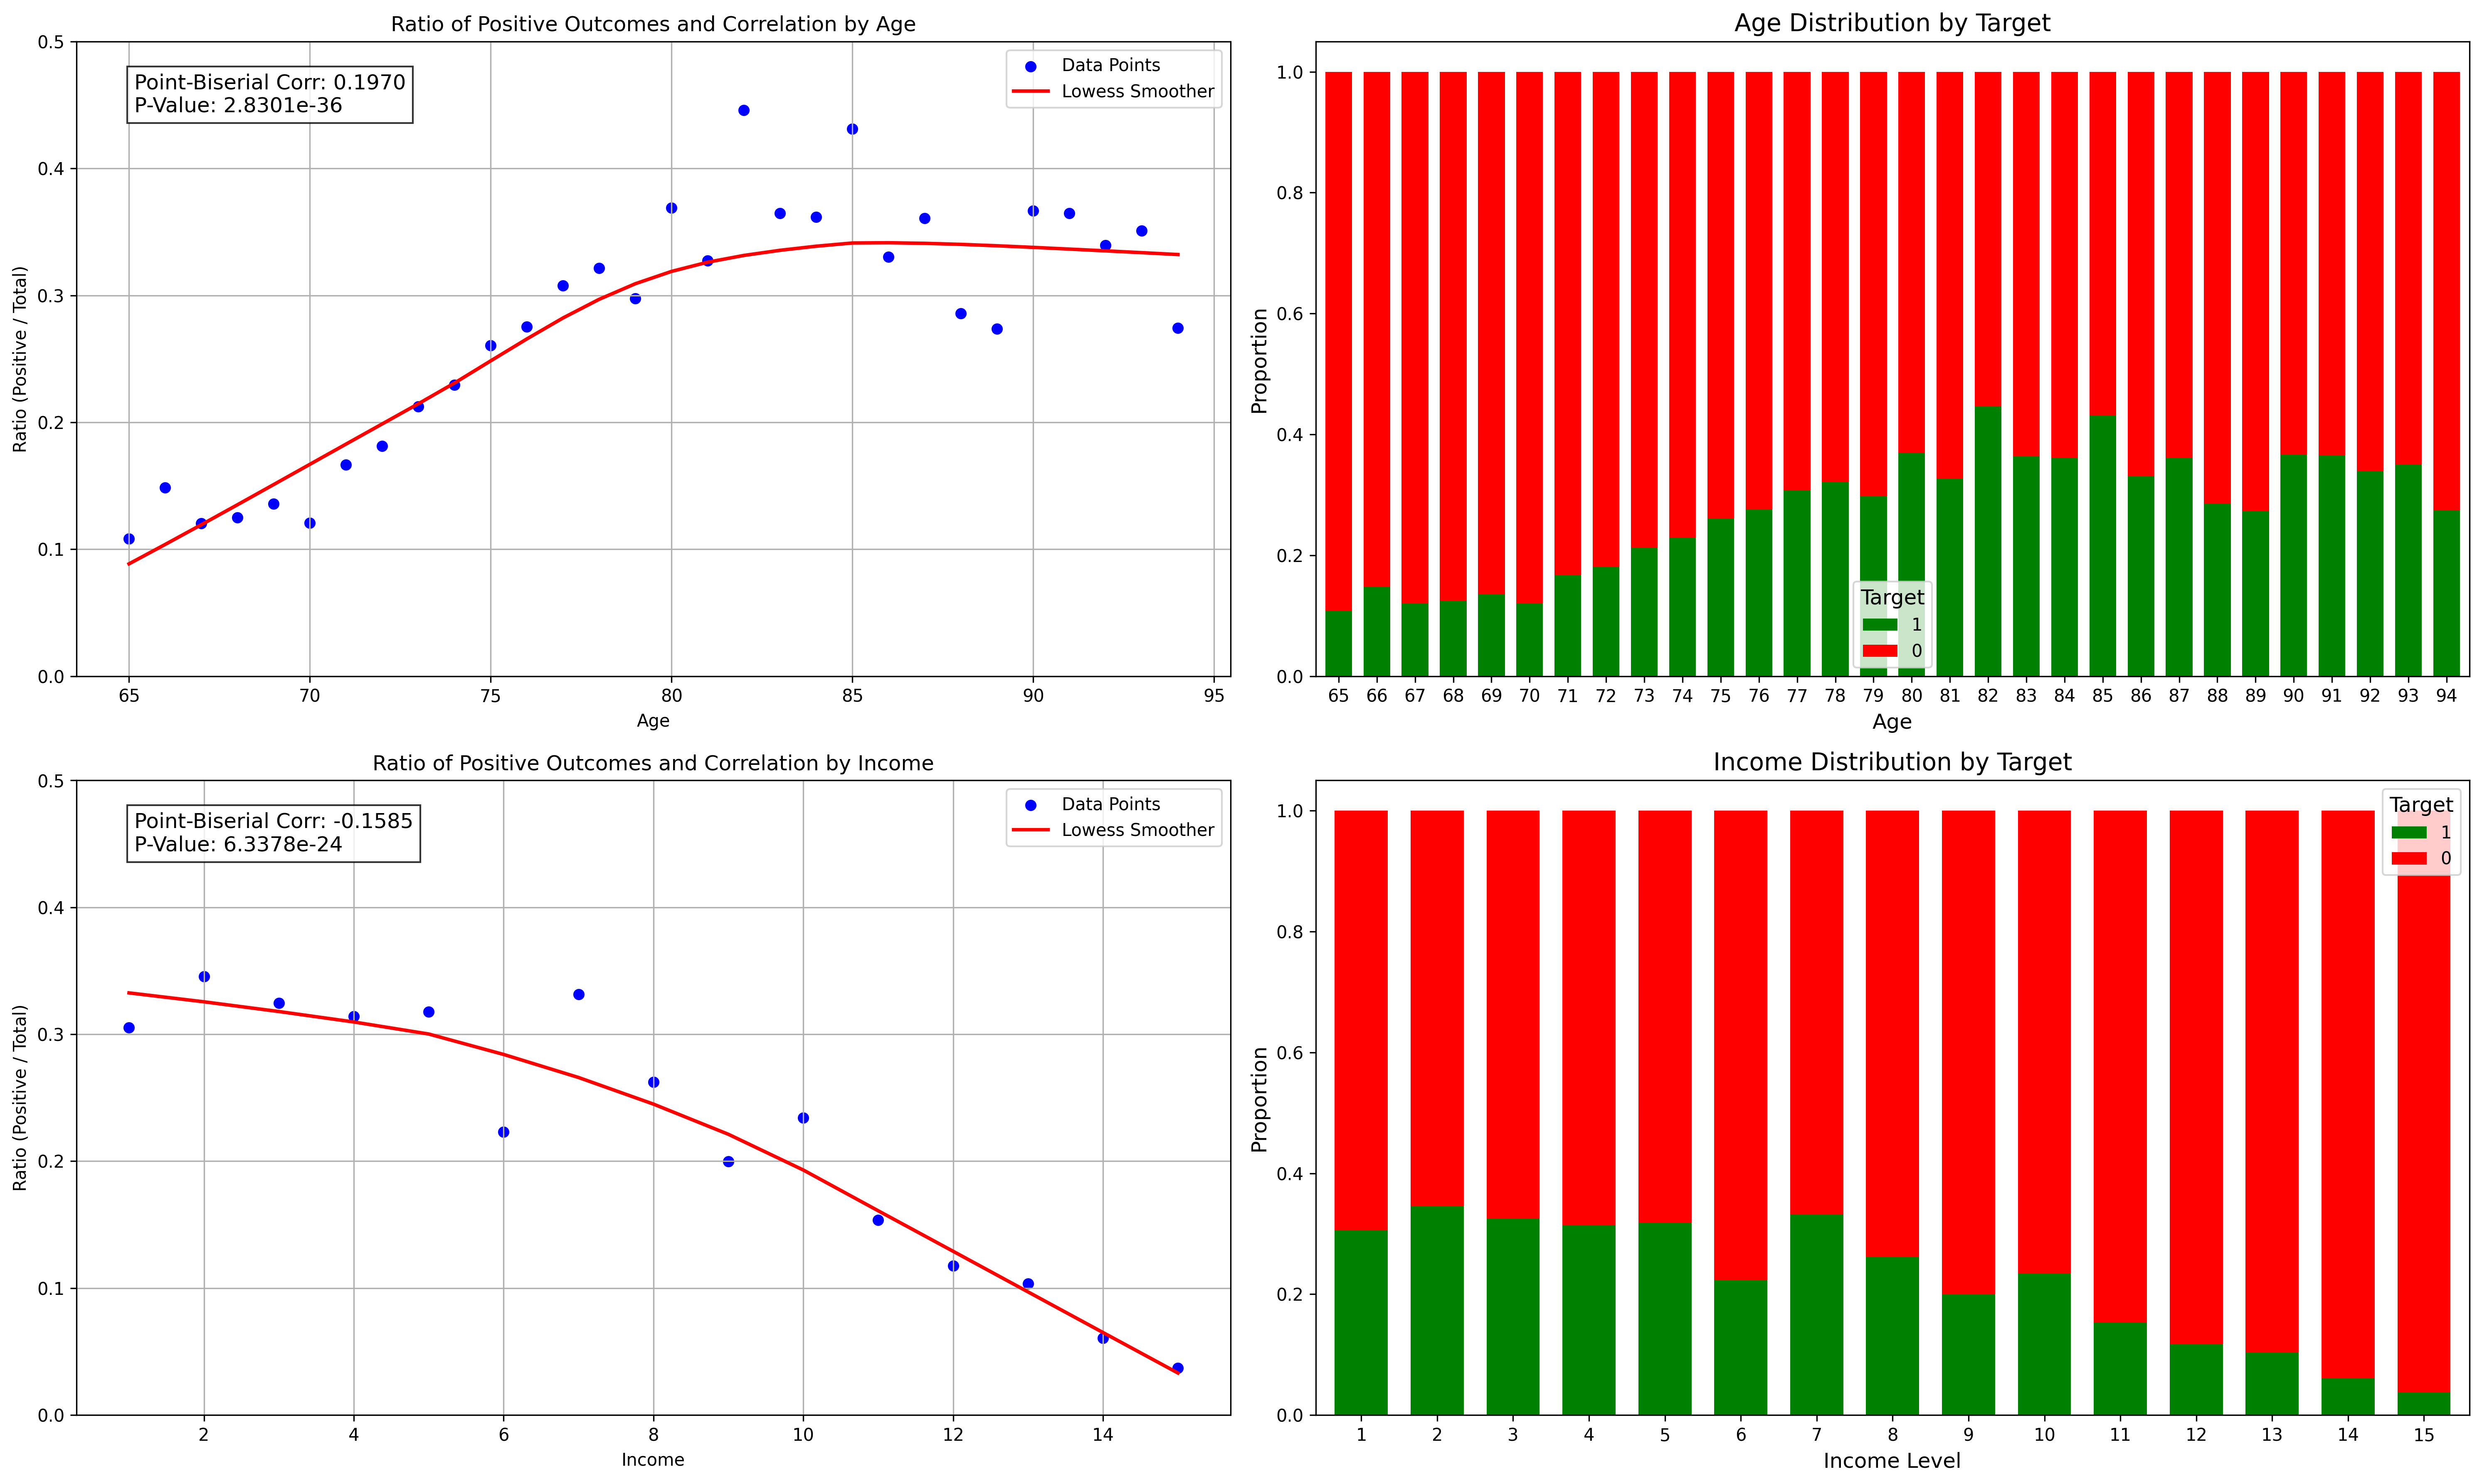

In [187]:
from scipy.stats import pointbiserialr

def plot_ratio_positive_negative_with_corr(df, continuous_var, categorical_var='target', positive_value=1, negative_value=0):
    grouped = df.groupby([continuous_var, categorical_var]).size().reset_index(name='count')
    pivot = grouped.pivot(index=continuous_var, columns=categorical_var, values='count').fillna(0)
    
    positive_counts = pivot[positive_value] if positive_value in pivot.columns else 0
    total_counts = positive_counts + pivot[negative_value] if negative_value in pivot.columns else positive_counts
    ratio = positive_counts / (total_counts + 1e-9)
    
    plot_df = pd.DataFrame({continuous_var: ratio.index, 'ratio_positive_negative': ratio.values})
    return plot_df, *pointbiserialr(df[continuous_var], df[categorical_var])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

age_plot_df, age_corr, age_p = plot_ratio_positive_negative_with_corr(data, 'age', 'target')
sns.scatterplot(x='age', y='ratio_positive_negative', data=age_plot_df, color='blue', s=50, label='Data Points', ax=ax1)
sns.regplot(x='age', y='ratio_positive_negative', data=age_plot_df, scatter=False, lowess=True, color='red', line_kws={'lw': 2}, label='Lowess Smoother', ax=ax1)
ax1.text(0.05, 0.95, f'Point-Biserial Corr: {age_corr:.4f}\nP-Value: {age_p:.4e}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
ax1.set_title('Ratio of Positive Outcomes and Correlation by Age')
ax1.set_xlabel('Age')
ax1.set_ylabel('Ratio (Positive / Total)')
ax1.set_ylim(0, 0.50)
ax1.legend()
ax1.grid()

age_proportions = data.groupby(["age", "target"]).size().unstack(fill_value=0).apply(lambda x: x / x.sum(), axis=1)
age_proportions[[1, 0]].plot(kind="bar", stacked=True, ax=ax2, width=0.7, legend=True, color=['green', 'red'])
ax2.set_title("Age Distribution by Target", fontsize=14)
ax2.set_ylabel("Proportion", fontsize=12)
ax2.set_xlabel("Age", fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, ha='center')
ax2.legend(title="Target", title_fontsize=12, fontsize=10)

income_plot_df, income_corr, income_p = plot_ratio_positive_negative_with_corr(data, 'income', 'target')
sns.scatterplot(x='income', y='ratio_positive_negative', data=income_plot_df, color='blue', s=50, label='Data Points', ax=ax3)
sns.regplot(x='income', y='ratio_positive_negative', data=income_plot_df, scatter=False, lowess=True, color='red', line_kws={'lw': 2}, label='Lowess Smoother', ax=ax3)
ax3.text(0.05, 0.95, f'Point-Biserial Corr: {income_corr:.4f}\nP-Value: {income_p:.4e}', transform=ax3.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
ax3.set_title('Ratio of Positive Outcomes and Correlation by Income')
ax3.set_xlabel('Income')
ax3.set_ylabel('Ratio (Positive / Total)')
ax3.set_ylim(0, 0.50)
ax3.legend()
ax3.grid()

income_proportions = data.groupby(["income", "target"]).size().unstack(fill_value=0).apply(lambda x: x / x.sum(), axis=1)
income_proportions[[1, 0]].plot(kind="bar", stacked=True, ax=ax4, width=0.7, legend=True, color=['green', 'red'])
ax4.set_title("Income Distribution by Target", fontsize=14)
ax4.set_ylabel("Proportion", fontsize=12)
ax4.set_xlabel("Income Level", fontsize=12)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0, ha='center')
ax4.legend(title="Target", title_fontsize=12, fontsize=10)

plt.tight_layout()
plt.show()

### Examination of the scatter plots 

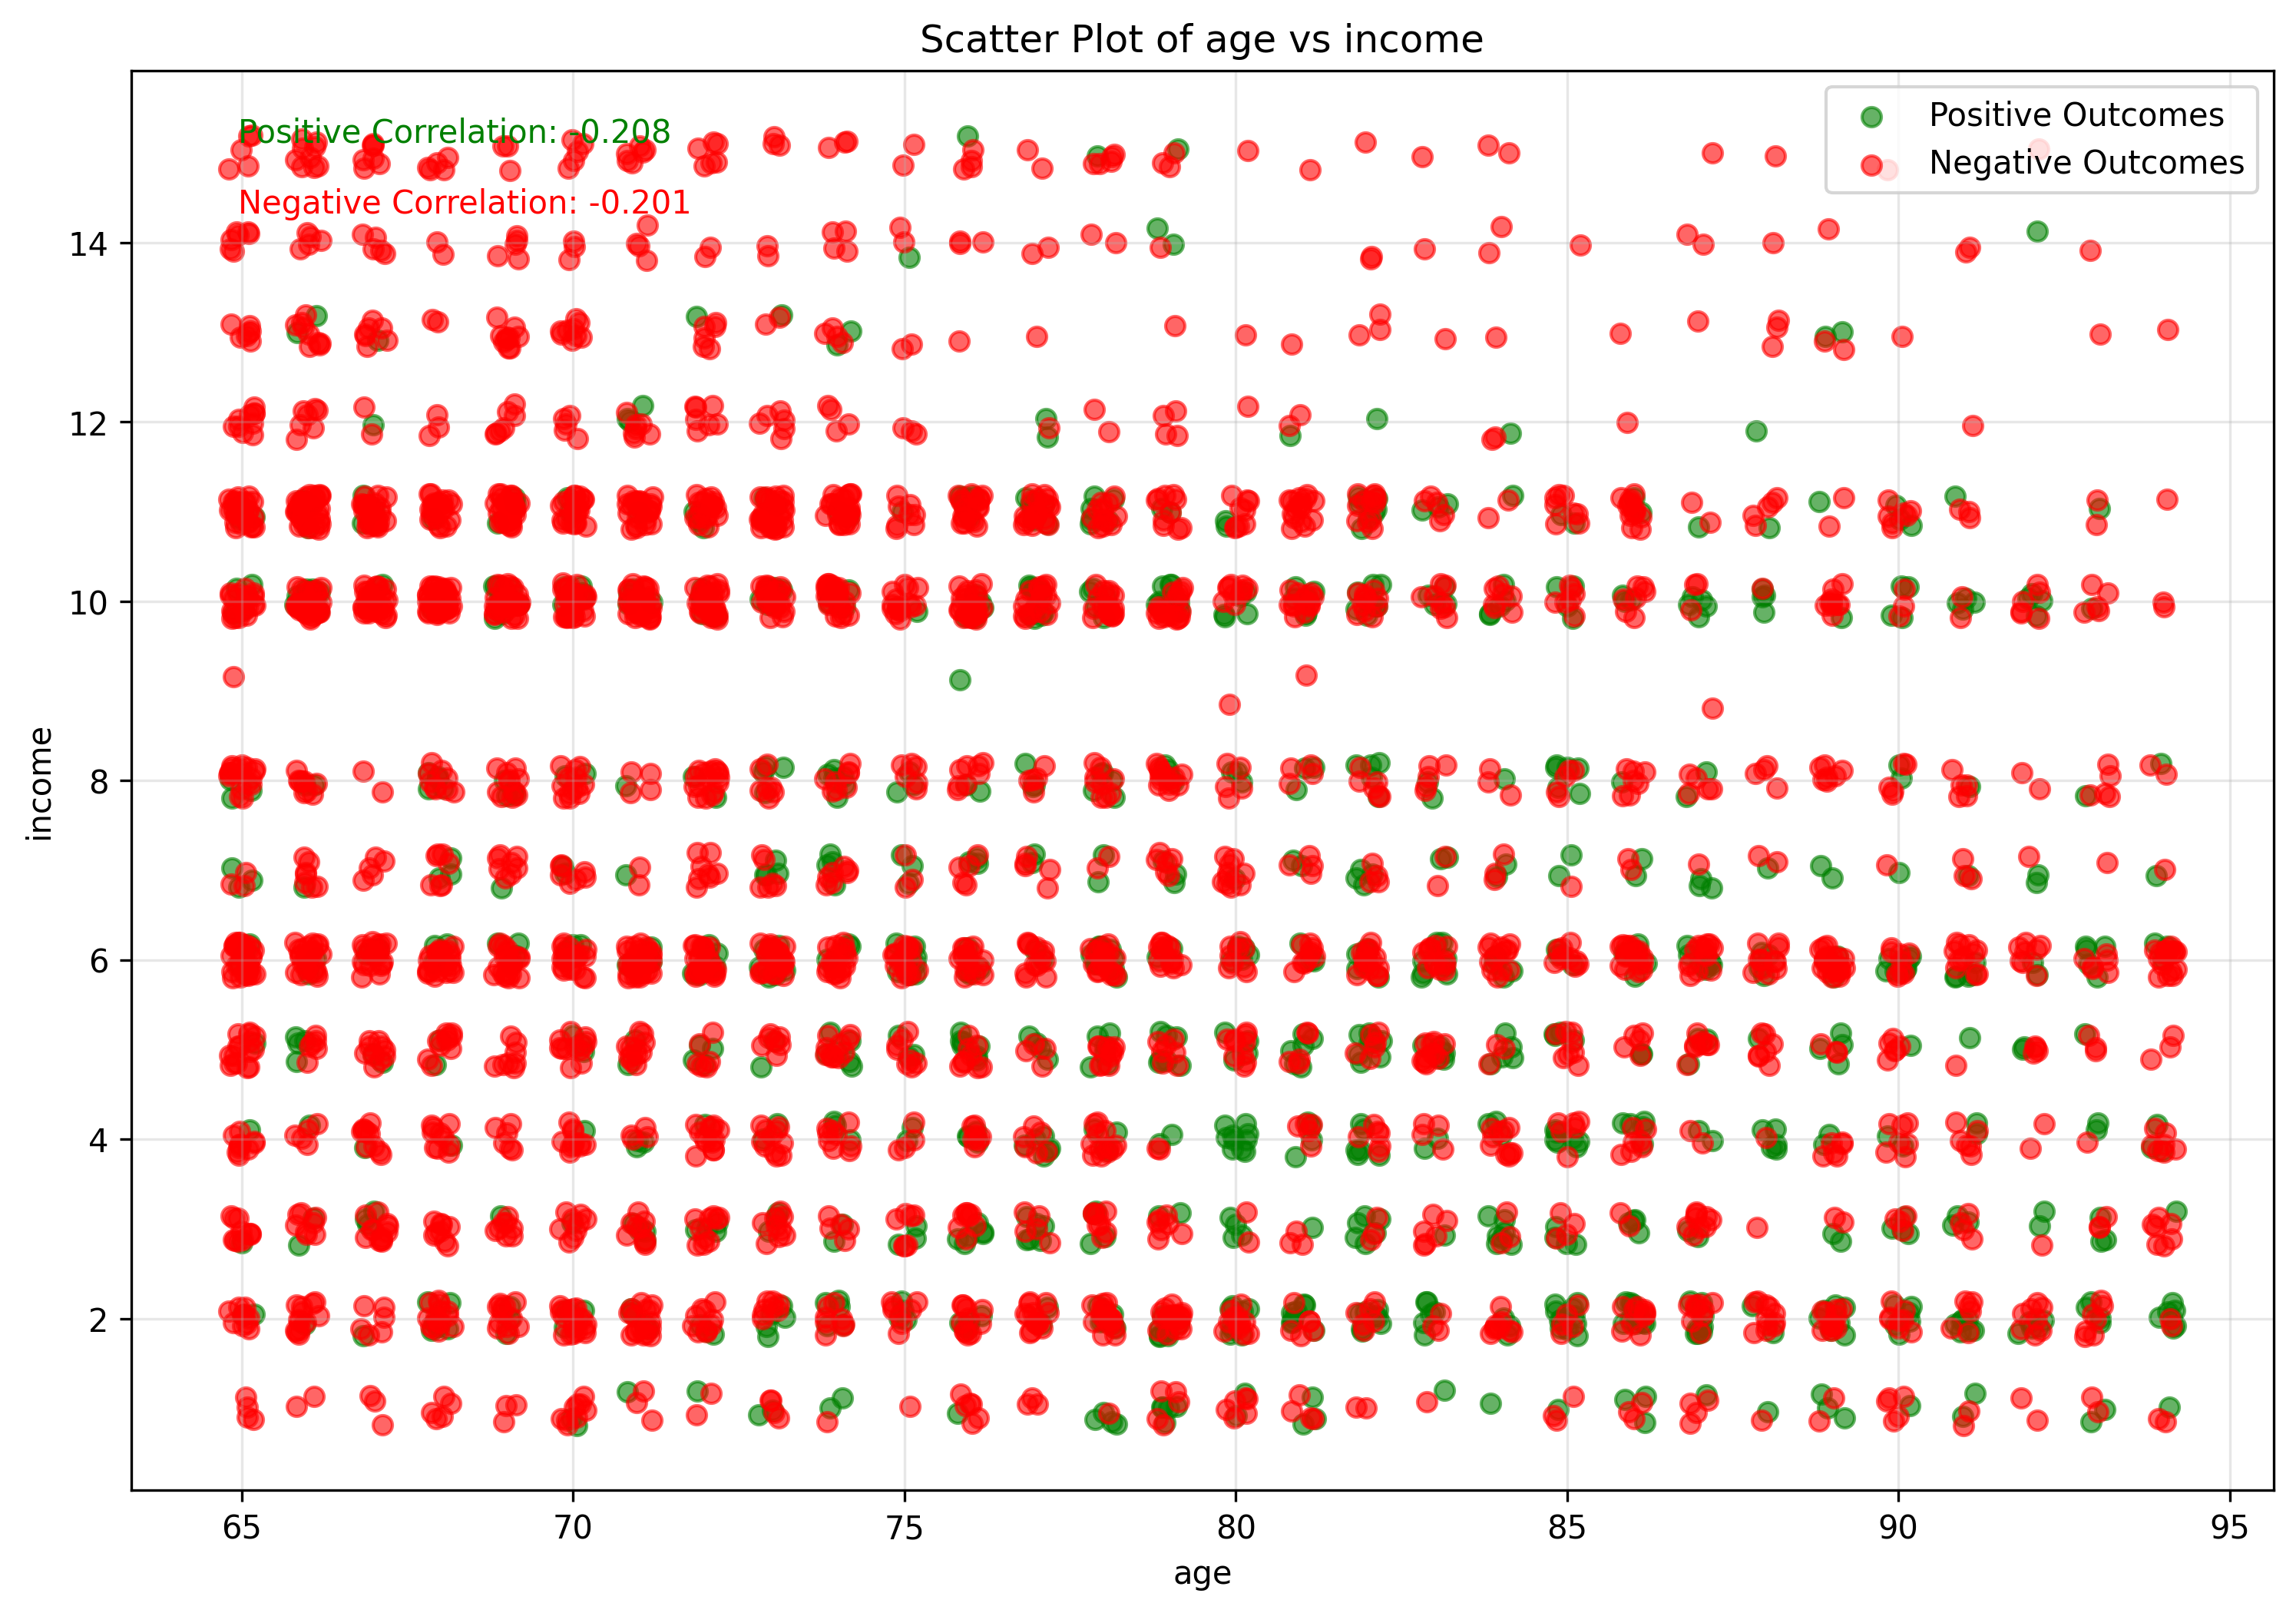

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_scatter_with_separate_correlations(df, continuous_vars, target_var='target', positive_value=1, negative_value=0):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    positive_data = df[df[target_var] == positive_value]
    negative_data = df[df[target_var] == negative_value]
    
    pos_corr = positive_data[continuous_vars[0]].corr(positive_data[continuous_vars[1]])
    neg_corr = negative_data[continuous_vars[0]].corr(negative_data[continuous_vars[1]])
    
    offset = 0.2
    pos_x = positive_data[continuous_vars[0]] + np.random.uniform(-offset, offset, len(positive_data))
    pos_y = positive_data[continuous_vars[1]] + np.random.uniform(-offset, offset, len(positive_data))
    neg_x = negative_data[continuous_vars[0]] + np.random.uniform(-offset, offset, len(negative_data))
    neg_y = negative_data[continuous_vars[1]] + np.random.uniform(-offset, offset, len(negative_data))
    
    plt.scatter(pos_x, pos_y, color='green', label='Positive Outcomes', alpha=0.6)
    plt.scatter(neg_x, neg_y, color='red', label='Negative Outcomes', alpha=0.6)
    
    plt.text(0.05, 0.95, f'Positive Correlation: {pos_corr:.3f}',
             transform=ax.transAxes, color='green', fontsize=10)
    plt.text(0.05, 0.90, f'Negative Correlation: {neg_corr:.3f}',
             transform=ax.transAxes, color='red', fontsize=10)
    
    plt.title(f'Scatter Plot of {continuous_vars[0]} vs {continuous_vars[1]}')
    plt.xlabel(continuous_vars[0])
    plt.ylabel(continuous_vars[1])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

continuous_vars = ['age', 'income']
target_var = 'target'

plot_scatter_with_separate_correlations(data, continuous_vars, target_var, positive_value=1, negative_value=0)

In [189]:
print(data[(data['age'] == 80) & (data['income'] == 4)].head(1))

    id  age  dist  income  gender  marital_status  target
92  93   80     1       4       0               1       1


# How Logistic Regresion models these relationships

Optimization terminated successfully.
         Current function value: 0.527865
         Iterations 6


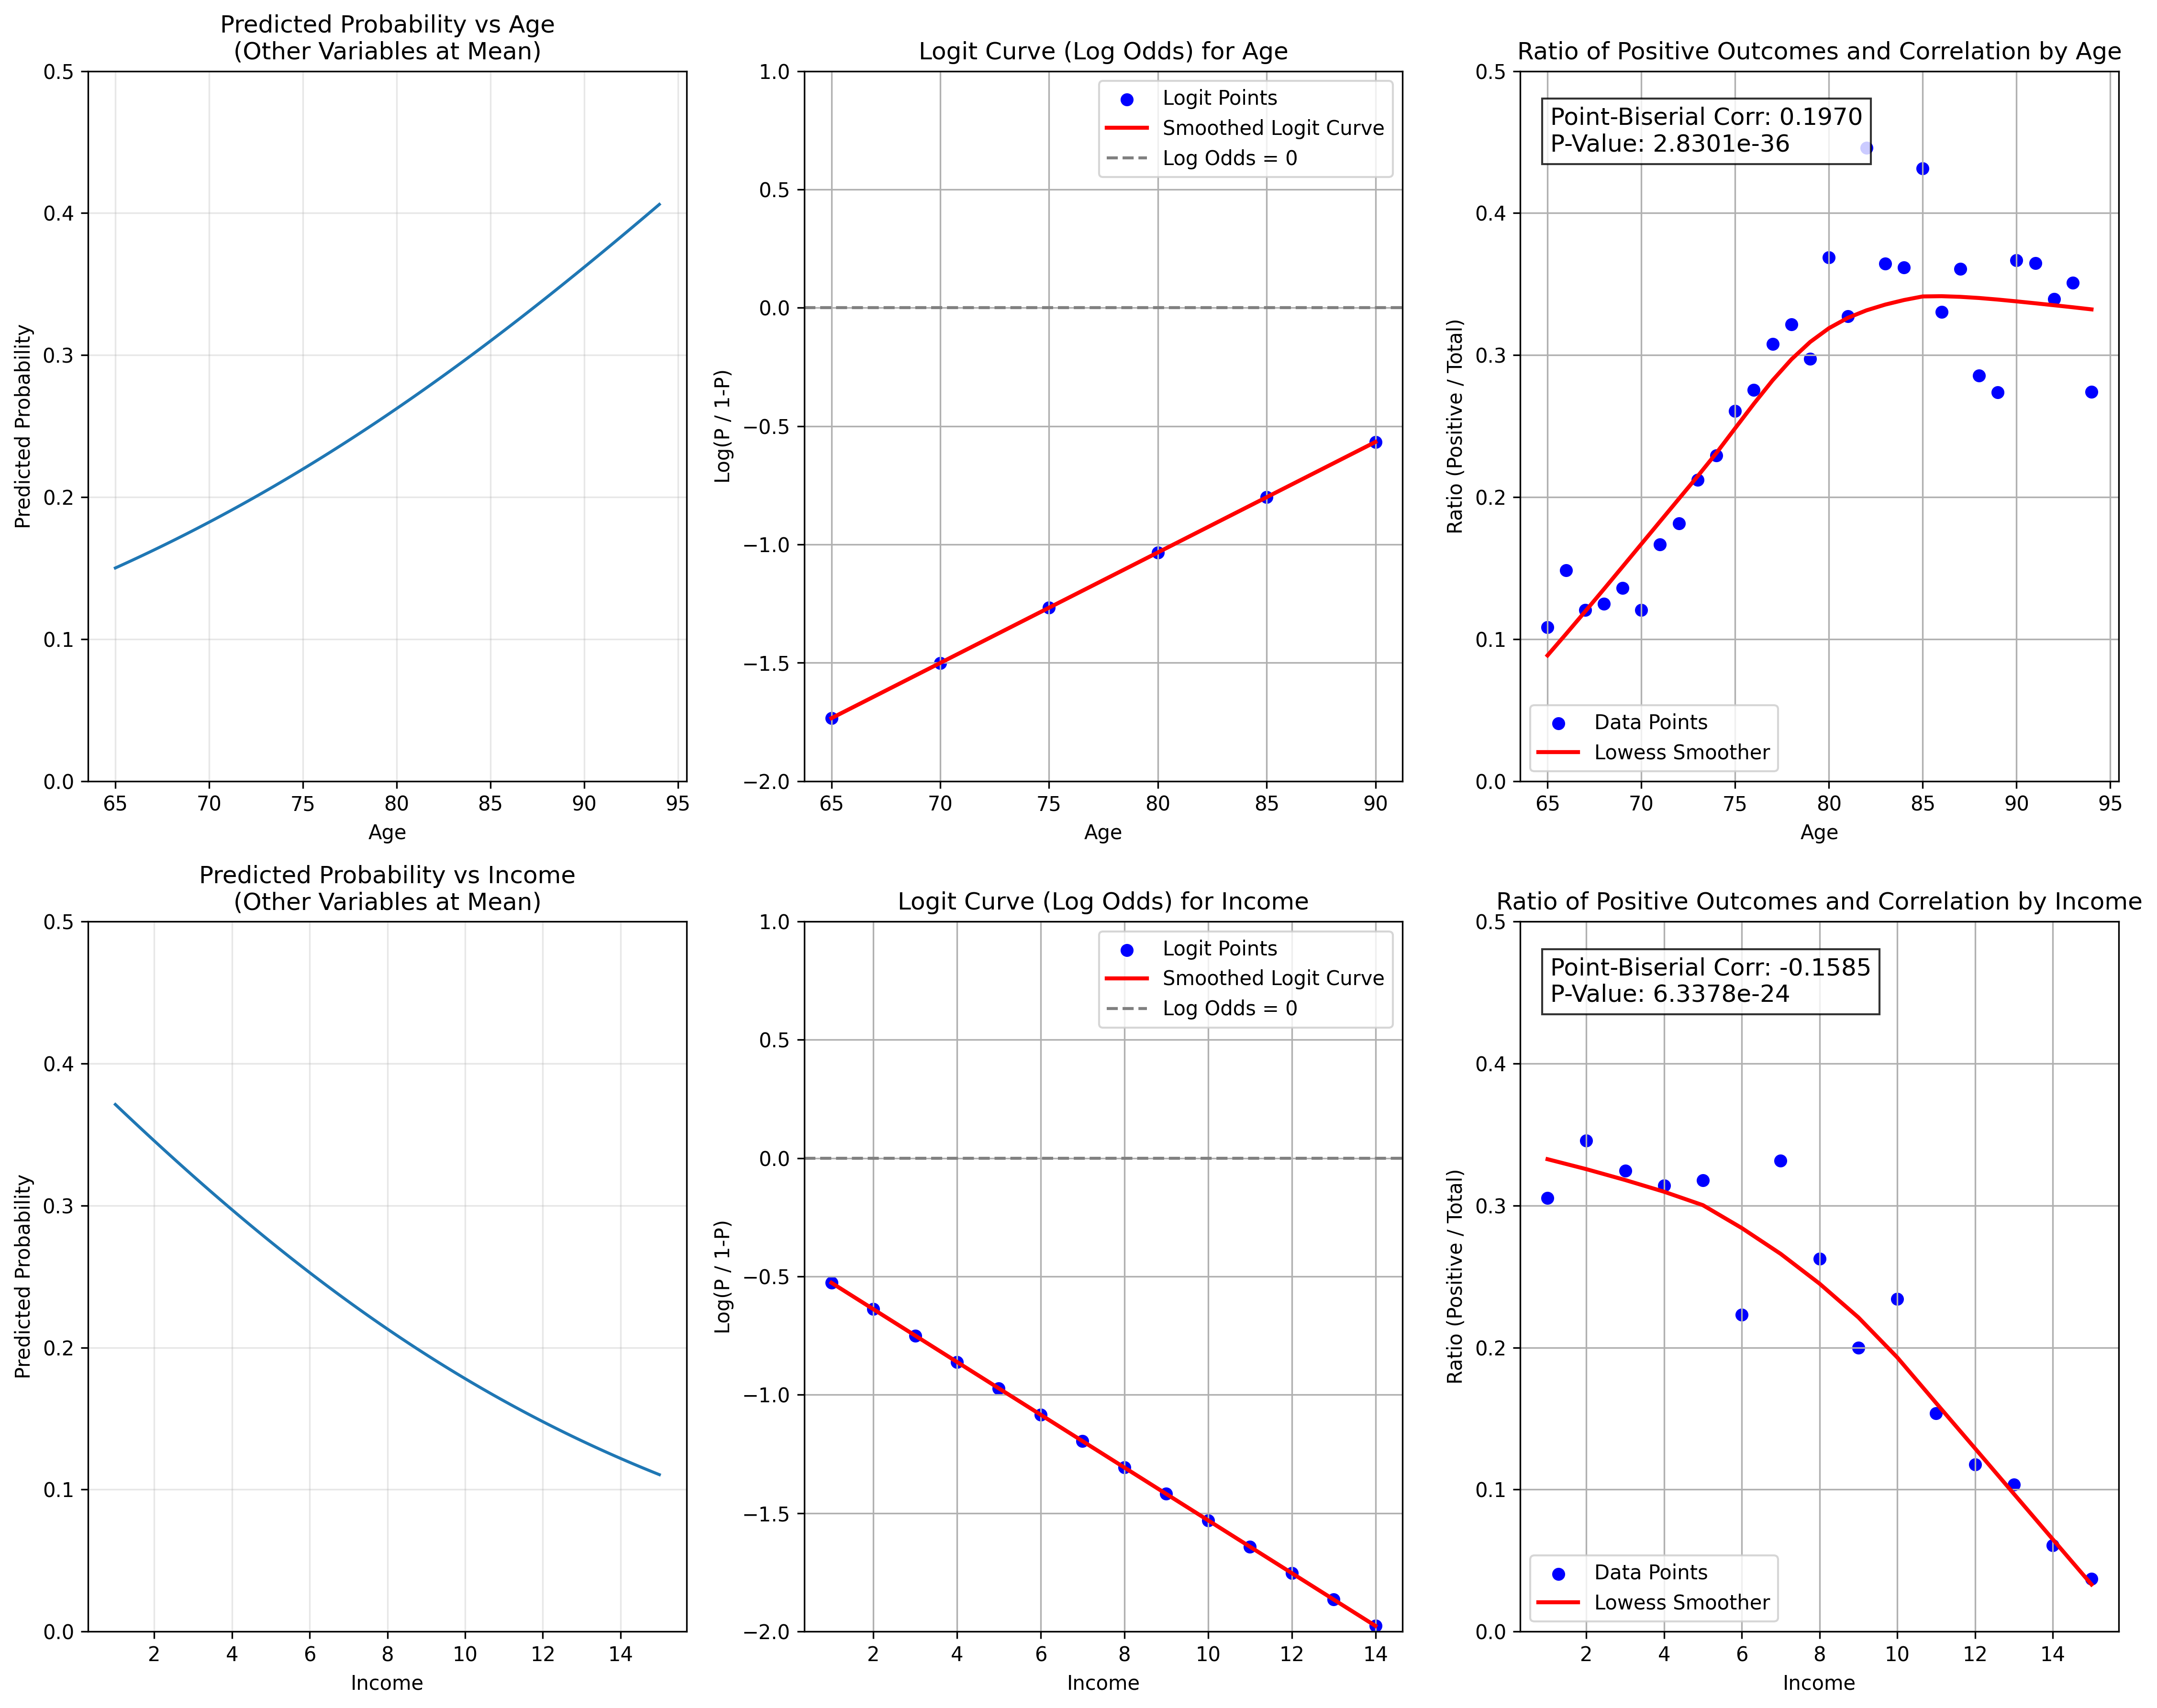

In [190]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

X = data[['age', 'dist', 'income', 'gender', 'marital_status']]
y = data['target']

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X, y)

fig, ((ax1, ax2, ax5), (ax3, ax4, ax6)) = plt.subplots(2, 3, figsize=(15, 12))

mean_values = X.mean()

x_range_age = np.linspace(X['age'].min(), X['age'].max(), 100)

pred_data_age = np.tile(mean_values, (100, 1))
pred_data_age = pd.DataFrame(pred_data_age, columns=X.columns)
pred_data_age['age'] = x_range_age

y_pred_age = lr_model.predict_proba(pred_data_age)[:, 1]

ax1.plot(x_range_age, y_pred_age)
ax1.set_title('Predicted Probability vs Age\n(Other Variables at Mean)')
ax1.set_ylabel('Predicted Probability')
ax1.set_xlabel('Age')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 0.5)

X_with_const = sm.add_constant(X)
logit_model = sm.Logit(y, X_with_const)
result = logit_model.fit()

feature_values_age = np.arange(X['age'].min(), X['age'].max(), 5)
fixed_predictors = mean_values.copy()
log_odds_age = []

for value in feature_values_age:
    temp_predictors = fixed_predictors.copy()
    temp_predictors['age'] = value
    predictors_with_const = sm.add_constant(temp_predictors.values.reshape(1, -1), has_constant='add')
    logit = np.dot(predictors_with_const, result.params)
    log_odds_age.append(logit[0])

plot_df_age = pd.DataFrame({
    'age': feature_values_age,
    'log_odds': log_odds_age
})

sns.scatterplot(x='age', y='log_odds', data=plot_df_age, color='blue', s=50, ax=ax2, label='Logit Points')
sns.regplot(x='age', y='log_odds', data=plot_df_age, scatter=False, lowess=True, 
            color='red', line_kws={'lw': 2}, ax=ax2, label='Smoothed Logit Curve')

ax2.set_title('Logit Curve (Log Odds) for Age')
ax2.set_xlabel('Age')
ax2.set_ylabel('Log(P / 1-P)')
ax2.set_ylim(-2, 1)
ax2.axhline(0, color='grey', linestyle='--', label='Log Odds = 0')
ax2.legend()
ax2.grid(True)

x_range_income = np.linspace(X['income'].min(), X['income'].max(), 100)

pred_data_income = np.tile(mean_values, (100, 1))
pred_data_income = pd.DataFrame(pred_data_income, columns=X.columns)
pred_data_income['income'] = x_range_income

y_pred_income = lr_model.predict_proba(pred_data_income)[:, 1]

ax3.plot(x_range_income, y_pred_income)
ax3.set_title('Predicted Probability vs Income\n(Other Variables at Mean)')
ax3.set_ylabel('Predicted Probability')
ax3.set_xlabel('Income')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 0.5)

feature_values_income = np.arange(X['income'].min(), X['income'].max(), 1)
fixed_predictors = mean_values.copy()
log_odds_income = []

for value in feature_values_income:
    temp_predictors = fixed_predictors.copy()
    temp_predictors['income'] = value
    predictors_with_const = sm.add_constant(temp_predictors.values.reshape(1, -1), has_constant='add')
    logit = np.dot(predictors_with_const, result.params)
    log_odds_income.append(logit[0])

plot_df_income = pd.DataFrame({
    'income': feature_values_income,
    'log_odds': log_odds_income
})

sns.scatterplot(x='income', y='log_odds', data=plot_df_income, color='blue', s=50, ax=ax4, label='Logit Points')
sns.regplot(x='income', y='log_odds', data=plot_df_income, scatter=False, lowess=True, 
            color='red', line_kws={'lw': 2}, ax=ax4, label='Smoothed Logit Curve')

ax4.set_title('Logit Curve (Log Odds) for Income')
ax4.set_xlabel('Income')
ax4.set_ylabel('Log(P / 1-P)')
ax4.set_ylim(-2, 1)
ax4.axhline(0, color='grey', linestyle='--', label='Log Odds = 0')
ax4.legend()
ax4.grid(True)

age_plot_df, age_corr, age_p = plot_ratio_positive_negative_with_corr(data, 'age', 'target')
sns.scatterplot(x='age', y='ratio_positive_negative', data=age_plot_df, color='blue', s=50, label='Data Points', ax=ax5)
sns.regplot(x='age', y='ratio_positive_negative', data=age_plot_df, scatter=False, lowess=True, color='red', line_kws={'lw': 2}, label='Lowess Smoother', ax=ax5)
ax5.text(0.05, 0.95, f'Point-Biserial Corr: {age_corr:.4f}\nP-Value: {age_p:.4e}', transform=ax5.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
ax5.set_title('Ratio of Positive Outcomes and Correlation by Age')
ax5.set_xlabel('Age')
ax5.set_ylabel('Ratio (Positive / Total)')
ax5.set_ylim(0, 0.50)
ax5.legend()
ax5.grid()

income_plot_df, income_corr, income_p = plot_ratio_positive_negative_with_corr(data, 'income', 'target')
sns.scatterplot(x='income', y='ratio_positive_negative', data=income_plot_df, color='blue', s=50, label='Data Points', ax=ax6)
sns.regplot(x='income', y='ratio_positive_negative', data=income_plot_df, scatter=False, lowess=True, color='red', line_kws={'lw': 2}, label='Lowess Smoother', ax=ax6)
ax6.text(0.05, 0.95, f'Point-Biserial Corr: {income_corr:.4f}\nP-Value: {income_p:.4e}', transform=ax6.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
ax6.set_title('Ratio of Positive Outcomes and Correlation by Income')
ax6.set_xlabel('Income')
ax6.set_ylabel('Ratio (Positive / Total)')
ax6.set_ylim(0, 0.50)
ax6.legend()
ax6.grid()

plt.tight_layout()
plt.show()

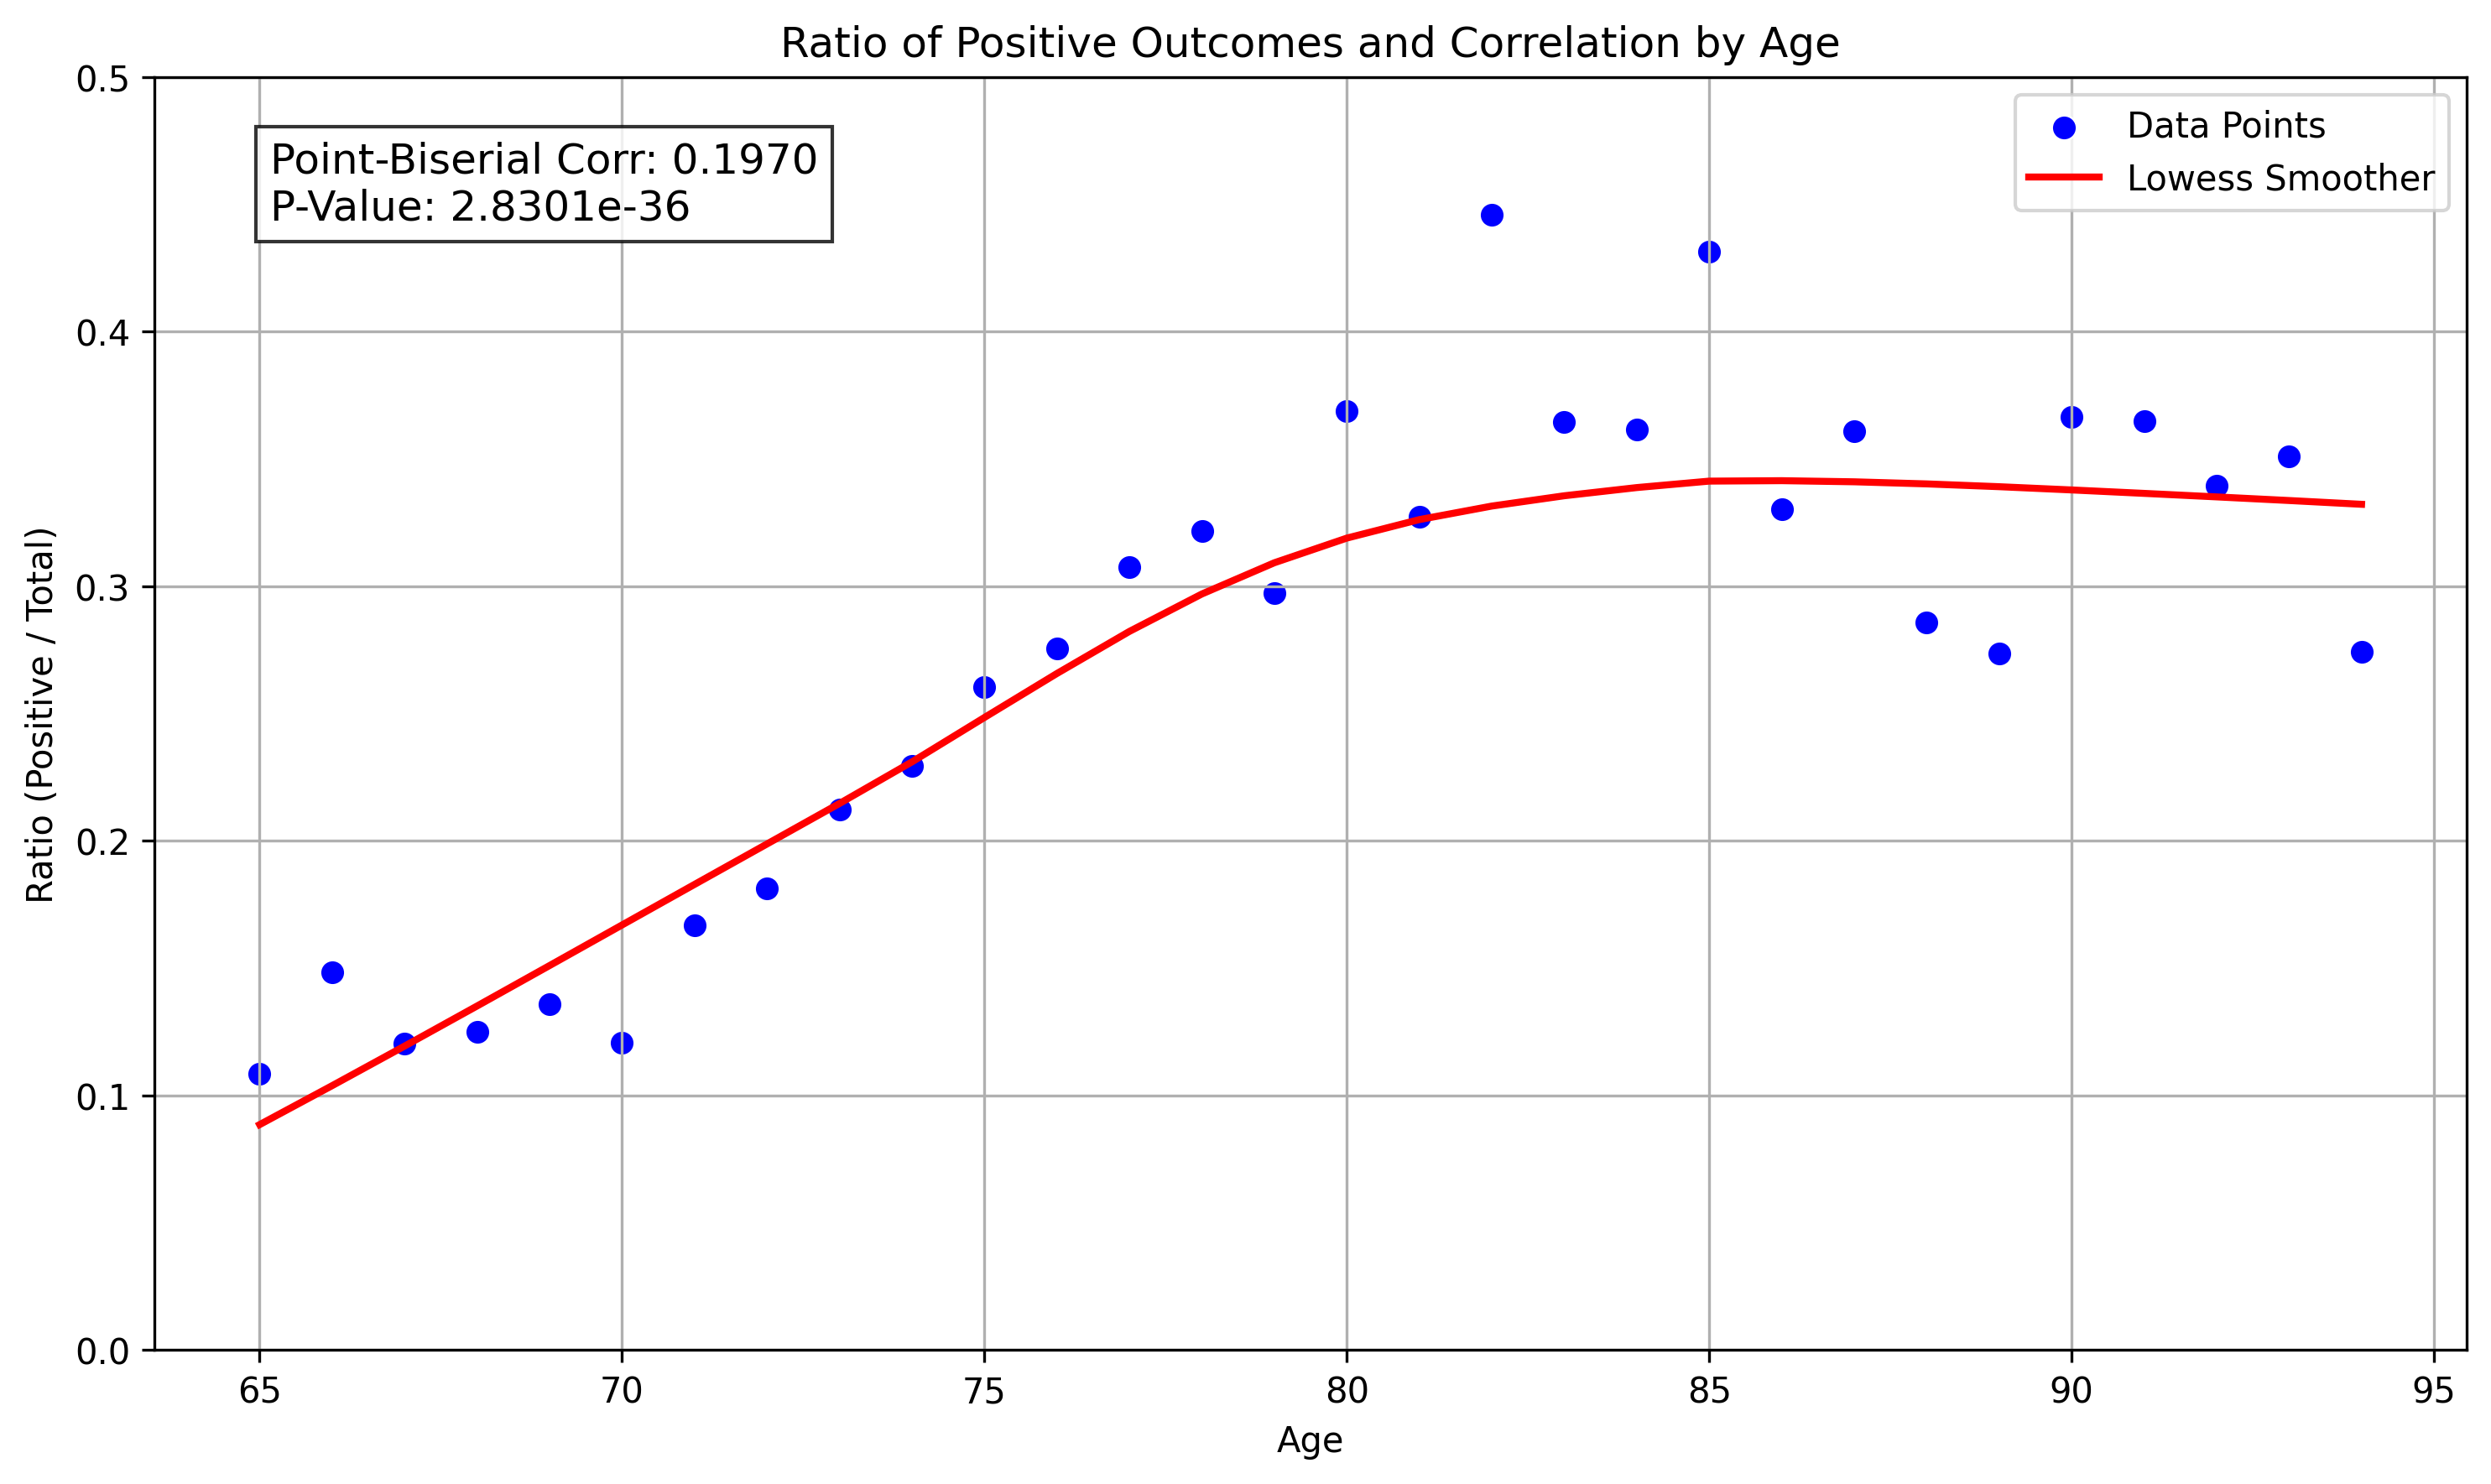

In [191]:
from scipy.stats import pointbiserialr

def plot_ratio_positive_negative_with_corr(df, continuous_var, categorical_var='target', positive_value=1, negative_value=0):
    grouped = df.groupby([continuous_var, categorical_var]).size().reset_index(name='count')
    pivot = grouped.pivot(index=continuous_var, columns=categorical_var, values='count').fillna(0)
    
    positive_counts = pivot[positive_value] if positive_value in pivot.columns else 0
    total_counts = positive_counts + pivot[negative_value] if negative_value in pivot.columns else positive_counts
    ratio = positive_counts / (total_counts + 1e-9)
    
    plot_df = pd.DataFrame({continuous_var: ratio.index, 'ratio_positive_negative': ratio.values})
    return plot_df, *pointbiserialr(df[continuous_var], df[categorical_var])

fig, ax = plt.subplots(figsize=(10, 6))

age_plot_df, age_corr, age_p = plot_ratio_positive_negative_with_corr(data, 'age', 'target')
sns.scatterplot(x='age', y='ratio_positive_negative', data=age_plot_df, color='blue', s=50, label='Data Points', ax=ax)
sns.regplot(x='age', y='ratio_positive_negative', data=age_plot_df, scatter=False, lowess=True, color='red', line_kws={'lw': 2}, label='Lowess Smoother', ax=ax)
ax.text(0.05, 0.95, f'Point-Biserial Corr: {age_corr:.4f}\nP-Value: {age_p:.4e}', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
ax.set_title('Ratio of Positive Outcomes and Correlation by Age')
ax.set_xlabel('Age')
ax.set_ylabel('Ratio (Positive / Total)')
ax.set_ylim(0, 0.50)
ax.legend()
ax.grid()

plt.tight_layout()
plt.show()

Optimization terminated successfully.
         Current function value: 0.542901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535794
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.539265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.541956
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.547609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.559628
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560484
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.545148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.543849
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.558019
  

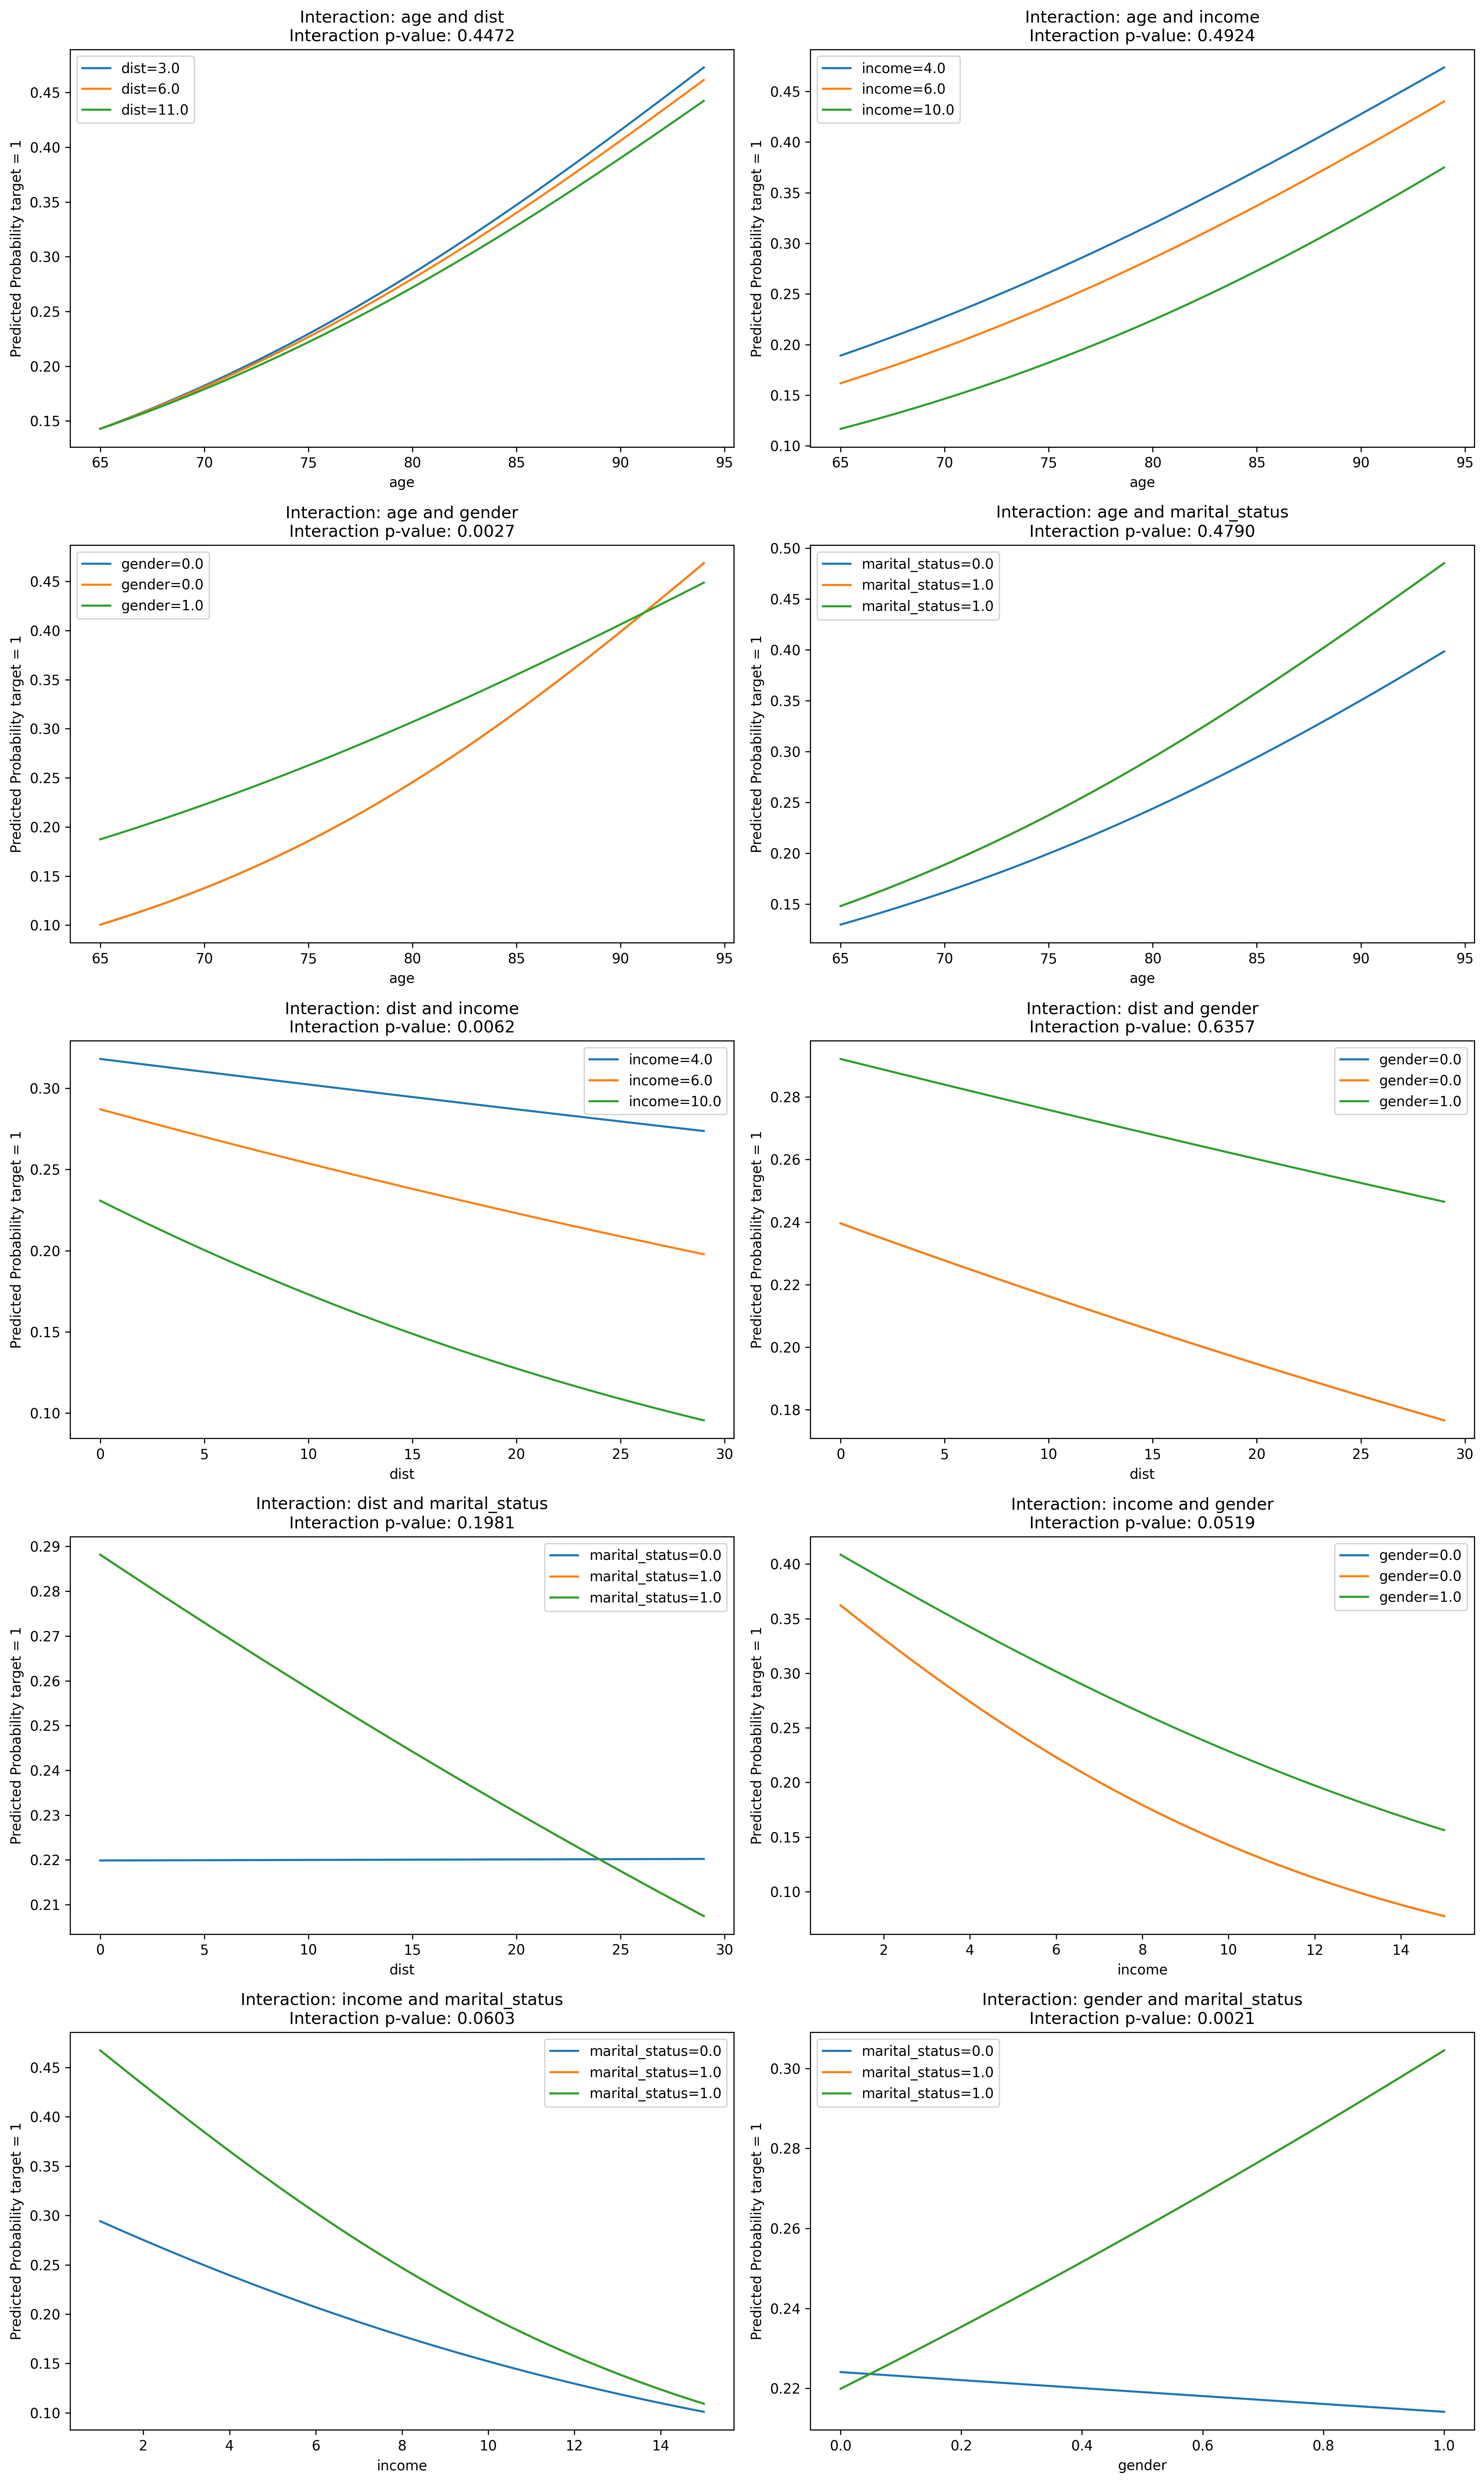


Significant interactions (p < 0.05):
age x gender
dist x income
gender x marital_status


In [192]:
variables = ['age', 'dist', 'income', 'gender', 'marital_status']

n_pairs = len(variables) * (len(variables) - 1) // 2
n_rows = (n_pairs + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows))
axes = axes.flatten()

significant_interactions = []
plot_idx = 0

for i, var1 in enumerate(variables):
    for j, var2 in enumerate(variables[i+1:], i+1):
        formula = f'target ~ {var1} * {var2}'
        model = sm.Logit.from_formula(formula, data=data).fit()
        
        interaction_pvalue = model.pvalues[f'{var1}:{var2}']
        
        if interaction_pvalue < 0.05:
            significant_interactions.append((var1, var2))
        
        var1_values = np.linspace(data[var1].min(), data[var1].max(), 100)
        var2_levels = np.percentile(data[var2], [25, 50, 75])
        
        for var2_level in var2_levels:
            df = pd.DataFrame({
                var1: var1_values,
                var2: var2_level
            })
            df['interaction'] = df[var1] * df[var2]
            df['predicted_prob'] = model.predict(sm.add_constant(df))
            
            axes[plot_idx].plot(df[var1], df['predicted_prob'], 
                              label=f'{var2}={var2_level:.1f}')
        
        axes[plot_idx].set_xlabel(var1)
        axes[plot_idx].set_ylabel('Predicted Probability target = 1')
        axes[plot_idx].legend()
        axes[plot_idx].set_title(f'Interaction: {var1} and {var2}\nInteraction p-value: {interaction_pvalue:.4f}')
        plot_idx += 1

for idx in range(plot_idx, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

print("\nSignificant interactions (p < 0.05):")
for var1, var2 in significant_interactions:
    print(f"{var1} x {var2}")
